### Initialization

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import xgboost as xgb
import os
import warnings
import xml.etree.ElementTree as ET
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector, Activation, ReLU, BatchNormalization
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

from math import sqrt

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


### Creating data

In [5]:
def create_dataframe_from_xml(xml_folder, root_findall):
    df = pd.DataFrame() 

    for filename in os.listdir(xml_folder):
        if filename.endswith(".xml"):
            xml_file = os.path.join(xml_folder, filename)

            # Analizza il file XML
            tree = ET.parse(xml_file)
            root = tree.getroot()

            # Inizializza una lista per memorizzare i dati
            data = []

            # Itera sugli elementi desiderati nel file XML
            for element in root.findall(root_findall):
                data_dict = {}
                for child in element:
                    data_dict[child.tag] = child.text
                data.append(data_dict)

            # Crea un DataFrame dai dati del file XML
            temp_df = pd.DataFrame(data)

            # Aggiungi il DataFrame del file corrente al DataFrame principale
            df = pd.concat([df, temp_df], ignore_index=True)


    return df

In [6]:
# Conta i valori NaN nel dataframe
def nan_counts_func(df):
    nan_counts = df.isna().sum()

    # Trova le colonne con valori NaN (se ce ne sono)
    columns_with_nan = nan_counts[nan_counts > 0]

    if columns_with_nan.empty:
        print("Nessun valore NaN nel DataFrame.")
    else:
        print("Colonne con valori NaN:")
        print(columns_with_nan)     

In [7]:
df_price = create_dataframe_from_xml("data_prices", './/Prezzi')


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data_prices'

In [51]:
df_stime = create_dataframe_from_xml("data_stimafabbisogno", './/marketintervaldetail')

In [4]:
# df_transiti = create_dataframe_from_xml("data_0", './/MgpTransiti')

# df_offerte = create_dataframe_from_xml("data_public_offers", './/OfferteOperatori')


In [5]:
# df_quantità = create_dataframe_from_xml("data_0", './/Quantita')

In [6]:
df_gas = create_dataframe_from_xml('data_gas', './/negoziazione_continua')

In [7]:
df_demand = create_dataframe_from_xml("data_fabbisogno", './/Fabbisogno')

## Data preprocessing

### GAS

In [37]:
df_temp = df_gas.groupby('NomeProdotto')['PrezzoMedio'].last().reset_index()
df_temp.columns = ['NomeProdotto', 'GAS']
df_temp['NomeProdotto'] = df_temp['NomeProdotto'].str.replace('MGP-', '')
df_temp['NomeProdotto'] = df_temp['NomeProdotto'].str.replace('WE-', '')

In [38]:
df_temp['GAS'] = df_temp['GAS'].fillna(method='ffill')
df_temp.dropna(inplace=True)
df_temp = df_temp[~df_temp['NomeProdotto'].str.match(r'\d{4}-\d{2}$')]

df_temp['DataG'] = pd.to_datetime(df_temp['NomeProdotto'])
df_temp = df_temp[['DataG', 'GAS']]
df_temp['GAS'] = pd.to_numeric(df_temp['GAS'], errors='coerce')


In [8]:
df_temp = df_temp.loc[df_temp.index.repeat(24)].reset_index(drop=True)

NameError: name 'df_temp' is not defined

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(df_temp[df_temp['DataG'].dt.year == 2018]['DataG'], 
         df_temp[df_temp['DataG'].dt.year == 2018]['GAS'], 
         marker='.', linestyle='-', color='lightseagreen', linewidth=1)

plt.title('GAS prezzo medio')
plt.xlabel('Data')
plt.ylabel('Prezzo Medio')
plt.show()

NameError: name 'df_temp' is not defined

<Figure size 1200x600 with 0 Axes>

### Offerte EDA

In [12]:
conteggio_operatori = df_offerte['OPERATORE'].value_counts().head(20)

# print(f" Ci sono {len(conteggio_operatori)} operatori presenti ")

print(f"Elenco degli operatori: \n {conteggio_operatori}" )


Elenco degli operatori: 
 OPERATORE
ENEL PRODUZIONE S.P.A.                   31657
Bilateralista                            12438
EDISON SPA                                9851
A2A SPA                                   8471
DXT COMMODITIES SA                        8035
AXPO ITALIA SPA                           5255
ENIPOWER S.P.A.                           5184
ENI PLENITUDE S.P.A. SOCIETA' BENEFIT     4200
BAYWA R.E. ENERGY TRADING S.R.L.          4094
SORGENIA S.P.A.                           4019
ALPIQ ENERGIA ITALIA S.p.A.               3749
ENGIE ITALIA SPA                          3431
DANSKE COMMODITIES A.S                    3336
IREN ENERGIA SPA                          3324
EP PRODUZIONE SPA                         3280
TIRRENO POWER S.P.A.                      2616
ENI SPA                                   2438
A2A ENERGIEFUTURE S.P.A.                  2328
EVISO S.P.A.                              2187
GSE SPA                                   2068
Name: count, dtype: int6

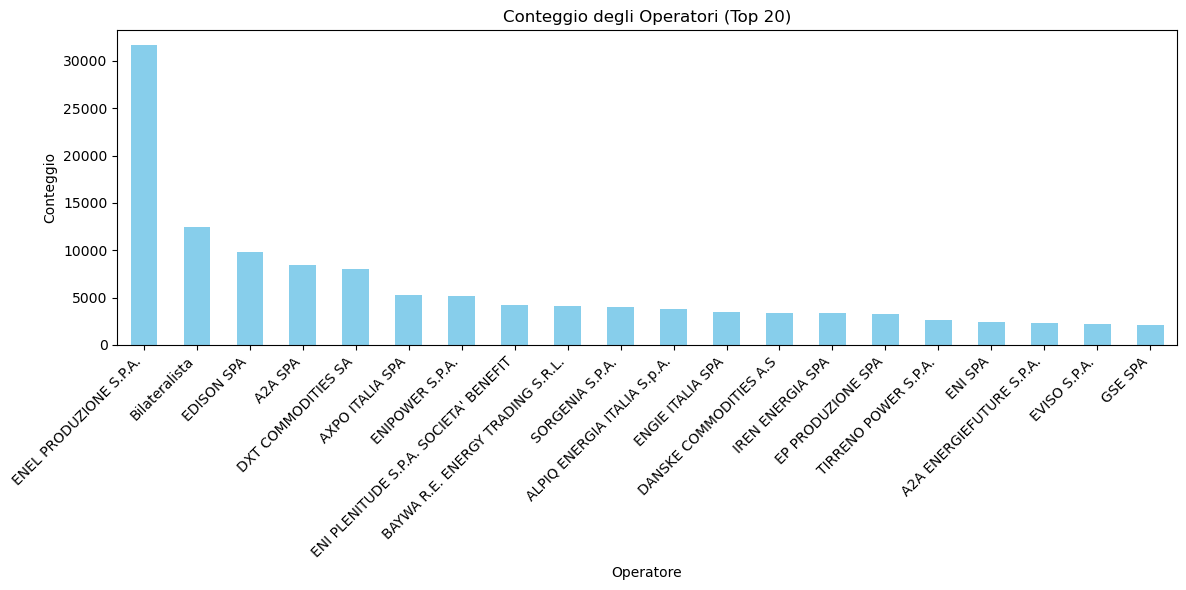

In [13]:
plt.figure(figsize=(12, 6))
conteggio_operatori.plot(kind='bar', color='skyblue')
plt.title('Conteggio degli Operatori (Top 20)')
plt.xlabel('Operatore')
plt.ylabel('Conteggio')
plt.xticks(rotation=45, ha='right')  # Ruota le etichette sull'asse x per una migliore leggibilità
plt.tight_layout()

plt.show()

In [14]:
top_operatori = df_offerte['OPERATORE'].value_counts().head(5).index

df_offerte = df_offerte[df_offerte['OPERATORE'].isin(top_operatori)]

In [15]:
df_offerte.head()

# df_offerte = df_offerte.drop(TRANSACTION_REFERENCE_NO], axis=1)

PURPOSE_CD TYPE_CD STATUS_CD MARKET_CD UNIT_REFERENCE_NO PERIOD  \
96         BID     REG       SUB      AFRR      UP_CASSANO_2      3   
97         BID     REG       SUB      AFRR      UP_CASSANO_2      1   
98         BID     REG       SUB      AFRR      UP_CASSANO_2      3   
99         BID     REG       SUB      AFRR      UP_CASSANO_2      1   
100        BID     REG       SUB      AFRR      UP_CASSANO_2      1   

    BID_OFFER_DATE_DT TRANSACTION_REFERENCE_NO ENERGY_PRICE_NO  \
96           20231014          995895595480551            3.00   
97           20231014          995895595480529            3.00   
98           20231014          995895595480551            3.00   
99           20231014          995895595480529            3.00   
100          20231014          995895595480529            3.00   

    GRID_SUPPLY_POINT_NO  ... OPERATORE SCOPE INTERVAL_NO QUANTITY_NO  \
96               PSR_123  ...   A2A SPA   GR1         NaN         NaN   
97               PSR_123  ...   A2A SPA   GR2         NaN         NaN   
98               PSR_123  ...   A2A SPA   GR3         NaN         NaN   
99               PSR_123  ...   A2A SPA   GR3         NaN         NaN   
100              PSR_123  ...   A2A SPA   GR1         NaN         NaN   

    AWARDED_QUANTITY_NO MERIT_ORDER_NO PARTIAL_QTY_ACCEPTED_IN  \
96                  NaN            NaN                     NaN   
97                  NaN            NaN                     NaN   
98                  NaN            NaN                     NaN   
99                  NaN            NaN                     NaN   
100                 NaN            NaN                     NaN   

    ADJ_QUANTITY_NO AWARDED_PRICE_NO BILATERAL_IN  
96              NaN              NaN          NaN  
97              NaN              NaN          NaN  
98              NaN              NaN          NaN  
99              NaN              NaN          NaN  
100             NaN              NaN          NaN  

[5 rows x 22 columns]

In [16]:
for col in df_offerte.columns:
    print(df_offerte[col].value_counts())


PURPOSE_CD
OFF    44625
BID    25827
Name: count, dtype: int64
TYPE_CD
REG     64692
STND     5760
Name: count, dtype: int64
STATUS_CD
SUB    35712
ACC    20220
REP     6849
REV     4695
REJ     2976
Name: count, dtype: int64
MARKET_CD
AFRR    35712
MGP     34740
Name: count, dtype: int64
UNIT_REFERENCE_NO
UP_ALTOMONTE_1     768
UP_AZOTATI_5       720
UP_CNTRLDSCND_1    696
UP_BUSSI_1         672
UP_LEVANTE_5       668
                  ... 
UP_TAVAZZANO_5       1
UP_STRONGOLI_1       1
UC_DP0062_SARD       1
UC_DP0062_CALA       1
UP_IGES_3            1
Name: count, Length: 948, dtype: int64
PERIOD
3     372
1     372
72    372
71    372
69    372
     ... 
29    372
32    372
27    372
28    372
96    372
Name: count, Length: 96, dtype: int64
BID_OFFER_DATE_DT
20231014    70452
Name: count, dtype: int64
TRANSACTION_REFERENCE_NO
995895595480551    6
995895595492448    6
995895595481247    6
995895595481269    6
995895595481258    6
                  ..
995895764973879    1
99589576497

### Demand

In [8]:
# Estrai le colonne numeriche da "PUN" a "XGRE"
numeric_columns = df_demand.loc[:, 'Italia':'SUD']

# Sostituisci le virgole con punti e converte in numeri float
for col in numeric_columns.columns:
    df_demand[col] = df_demand[col].str.replace(',', '.').astype(float)

In [9]:
df_demand['Data'] = pd.to_datetime(df_demand['Data'])

df_demand = df_demand.drop(columns = 'Mercato')


In [10]:
df_demand.rename(columns={"Italia": "Total_Load"}, errors="raise")

Data Ora  Total_Load      CNOR      CSUD       NORD      SARD  \
0     2018-01-01   1   22977.651  2403.224  4218.536  11636.149   860.269   
1     2018-01-01   2   21814.188  2265.768  4006.379  11070.182   822.254   
2     2018-01-01   3   20764.652  2170.493  3722.489  10684.283   787.863   
3     2018-01-01   4   19970.904  2077.601  3508.763  10356.197   767.163   
4     2018-01-01   5   19493.972  2014.744  3367.714  10210.665   748.852   
...          ...  ..         ...       ...       ...        ...       ...   
52171 2023-12-14  20   41058.750  3545.182  7495.006  23222.984  1150.682   
52172 2023-12-14  21   38835.604  3312.119  7160.795  21736.368  1144.456   
52173 2023-12-14  22   35748.302  2981.959  6575.470  20065.541  1066.333   
52174 2023-12-14  23   32119.056  2641.487  5852.769  18068.191   958.771   
52175 2023-12-14  24   29249.681  2390.230  5259.831  16633.859   869.806   

           SICI       SUD     CALA  
0      1683.577  2175.896      NaN  
1      1607.622  2041.983      NaN  
2      1499.219  1900.305      NaN  
3      1443.188  1817.992      NaN  
4      1390.137  1761.860      NaN  
...         ...       ...      ...  
52171  2269.802  2565.396  809,698  
52172  2208.225  2500.126  773,515  
52173  2048.778  2292.304  717,917  
52174  1858.157  2096.527  643,154  
52175  1655.178  1879.605  561,172  

[52176 rows x 10 columns]

### Quantità

In [18]:
df_quantità.columns

Index(['Data', 'Mercato', 'Ora', 'TOTALE_ACQUISTI', 'NAT_ACQUISTI',
       'CALA_ACQUISTI', 'CNOR_ACQUISTI', 'CSUD_ACQUISTI', 'NORD_ACQUISTI',
       'SARD_ACQUISTI', 'SICI_ACQUISTI', 'SUD_ACQUISTI', 'AUST_ACQUISTI',
       'COAC_ACQUISTI', 'COUP_ACQUISTI', 'CORS_ACQUISTI', 'FRAN_ACQUISTI',
       'GREC_ACQUISTI', 'SLOV_ACQUISTI', 'SVIZ_ACQUISTI', 'BSP_ACQUISTI',
       'MALT_ACQUISTI', 'XAUS_ACQUISTI', 'XFRA_ACQUISTI', 'MONT_ACQUISTI',
       'XGRE_ACQUISTI', 'TOTALE_VENDITE', 'NAT_VENDITE', 'CALA_VENDITE',
       'CNOR_VENDITE', 'CSUD_VENDITE', 'NORD_VENDITE', 'SARD_VENDITE',
       'SICI_VENDITE', 'SUD_VENDITE', 'AUST_VENDITE', 'COAC_VENDITE',
       'COUP_VENDITE', 'CORS_VENDITE', 'FRAN_VENDITE', 'GREC_VENDITE',
       'SLOV_VENDITE', 'SVIZ_VENDITE', 'BSP_VENDITE', 'MALT_VENDITE',
       'XAUS_VENDITE', 'XFRA_VENDITE', 'MONT_VENDITE', 'XGRE_VENDITE',
       'TOTITABSP_VENDITE', 'TOTITABSP_ACQUISTI'],
      dtype='object')

In [19]:
df_quantità['Data'] = pd.to_datetime(df_quantità['Data'])

In [20]:
numeric_columns = df_quantità.loc[:, 'TOTALE_ACQUISTI':'TOTITABSP_ACQUISTI']

# Sostituisci le virgole con punti e converte in numeri float
for col in numeric_columns.columns:
    df_quantità[col] = df_quantità[col].str.replace(',', '.').astype(float)


In [21]:
df_quantità = df_quantità.drop(columns=['Mercato', 'Ora', 'Data'])
df_quantità_acquisti = df_quantità.loc[:, :'SUD_ACQUISTI']
df_quantità_vendite = df_quantità.loc[:, 'TOTALE_VENDITE':'SUD_VENDITE']

df_quantità = pd.concat([df_quantità_acquisti, df_quantità_vendite], axis=1)

In [22]:
df_quantità.count()

TOTALE_ACQUISTI    16776
NAT_ACQUISTI       16776
CALA_ACQUISTI      16776
CNOR_ACQUISTI      16776
CSUD_ACQUISTI      16776
NORD_ACQUISTI      16776
SARD_ACQUISTI      16776
SICI_ACQUISTI      16776
SUD_ACQUISTI       16776
TOTALE_VENDITE     16776
NAT_VENDITE        16776
CALA_VENDITE       16776
CNOR_VENDITE       16776
CSUD_VENDITE       16776
NORD_VENDITE       16776
SARD_VENDITE       16776
SICI_VENDITE       16776
SUD_VENDITE        16776
dtype: int64

### Stima e Prezzi

In [67]:
df_price = df_price.loc[:, :'SUD']
numeric_columns = df_price.loc[:, 'PUN':'SUD']
# Sostituisci le virgole con punti e converte in numeri float
for col in numeric_columns.columns:
    df_price[col] = df_price[col].str.replace(',', '.').astype(float)
# Converti la colonna "Data" in formato datetime se non lo è già
df_price['Data'] = pd.to_datetime(df_price['Data'])
df_stime['Data'] = pd.to_datetime(df_stime['Data'])

df_stime = df_stime.drop(columns = 'Mercato')
df_price = df_price.drop(columns = 'Mercato')

df_price = df_price.drop(df_price.columns[11:25], axis=1)
df_stime.columns = list(df_stime.columns[:3]) + [col + '_stima' for col in df_stime.columns[3:]]

for col in df_stime.columns[2:]:
    df_stime[col] = df_stime[col].astype(float)
df_stime.head()
df_stime = df_stime.iloc[:, 2:]
df_stime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51288 entries, 0 to 51287
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Totale      51288 non-null  float64
 1   CNOR_stima  51288 non-null  float64
 2   CSUD_stima  51288 non-null  float64
 3   NORD_stima  51288 non-null  float64
 4   SARD_stima  51288 non-null  float64
 5   SICI_stima  51288 non-null  float64
 6   SUD_stima   51288 non-null  float64
 7   CALA_stima  25560 non-null  float64
dtypes: float64(8)
memory usage: 3.1 MB


In [4]:
from matplotlib.dates import DateFormatter, MonthLocator


# Crea un grafico per la colonna "PUN"
plt.figure(figsize=(12, 6))
plt.plot(df_price['Data'], df_price['PUN'], marker='o', markersize=2, linestyle='-', linewidth=0.5, color='b')
plt.xlabel('Data')
plt.ylabel('Valore PUN')
plt.title('Andamento temporale di PUN')
plt.xticks(rotation=45)

# Imposta il formato dell'asse x per mostrare solo i mesi di riferimento
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(MonthLocator(interval=3))  # Mostra un mese ogni intervallo

plt.show()


NameError: name 'df_price' is not defined

<Figure size 1200x600 with 0 Axes>

### Concateno i dataset

In [71]:
df = pd.concat([df_price, df_demand, df_temp], axis=1)

In [72]:
df['Ora'] = pd.to_numeric(df['Ora'], errors='coerce')
df.info()

#df = df.rename(columns={"Totale": "Total_Load_est"}, errors="raise")

TypeError: arg must be a list, tuple, 1-d array, or Series

In [30]:
df = df.drop(columns='DataG', axis=1)
df = df.dropna()

Aggiungo features temporali

In [31]:
def split_temporal_indices(df):
    # Estrai l'anno, il mese, il giorno della settimana e l'ora dalla colonna 'DataCompleta'
    df['Mese'] = df['Data'].dt.month
    df['GiornoSettimana'] = df['Data'].dt.dayofweek
    df['Weekend'] = df['GiornoSettimana'].apply(lambda x: 1 if x > 4 else 0)  # 5 e 6 rappresentano sabato e domenica
    
    return df

df = split_temporal_indices(df)


In [32]:
ora_column = df.pop('Ora') 
df['Ora'] = ora_column
df['Ora'] = df['Ora'].astype(int)

In [ ]:
df_demand['Italia']

0        27422.121
1        25774.874
2        24860.373
3        24554.950
4        24524.728
           ...    
16075    39061.502
16076    37061.908
16077    34029.609
16078    30768.603
16079    28043.763
Name: Italia, Length: 16080, dtype: float64

In [33]:
df['Total_Load'] = df_demand['Italia']

### Adding temporal features

In [50]:
# df.reset_index(inplace=True)

df['Time_data'] = df['Data'].apply(lambda t: pd.Timestamp(t).normalize().tz_localize('CET').tz_convert('UTC')) + \
                    df['Ora'].apply(lambda h: pd.Timedelta(hours=h))

df.set_index('Time_data', inplace=True)

In [51]:
from datetime import date
from workalendar.europe import Italy


holidays_2023 = Italy().holidays(2023)
holidays_2022 = Italy().holidays(2022)
holiday_dates23 = [date for date, _ in holidays_2023]
holiday_dates22 = [date for date, _ in holidays_2022]

holiday_dates = holiday_dates22 + holiday_dates23

In [53]:
holiday_dates_str = [date.strftime('%Y-%m-%d') for date in holiday_dates]

In [55]:
# crea un indice date time index
date_range = pd.date_range(start="2022-01-15", end="2023-12-14", freq='H')


df_holiday = pd.DataFrame(index=date_range)

# Add a column 'is_holiday' and set values based on holiday_dates_str
df_holiday['is_holiday'] = df_holiday.index.strftime('%Y-%m-%d').isin(holiday_dates_str).astype(int)


In [56]:
# Applico la stessa timezone a df_holiday
df_holiday.index = df_holiday.index.tz_localize(df.index.tz)

In [57]:
df = pd.merge(df, df_holiday, left_index=True, right_index=True, how='left')

# If there are missing values in the 'is_holiday' column, fill them with 0
# df['is_holiday'].fillna(0, inplace=True)


In [58]:
# df = df.drop(['is_holiday_x', 'is_holiday_y'], axis=1) #non so come siano usciti fuori

In [59]:
df = df.dropna()
df['is_holiday'] = df['is_holiday'].astype(int)

KeyError: 'is_holiday'

In [60]:
df['is_holiday'].describe()
print(f'Ci sono {df["is_holiday"].sum() // 24} giorni di vacanza nel dataframe') # usare " e non '


KeyError: 'is_holiday'

In [61]:
# # metodo barbaro
# date_list = ['2022-12-08', '2022-12-25', '2022-12-26', '2023-01-01', '2023-01-06', '2023-04-10', '2023-04-25', '2023-05-01', '2023-06-02',
#              '2023-08-15', '2023-11-01', '2023-12-08', '2023-12-25', '2023-12-26']

# datetime_index = pd.to_datetime(date_list, utc=True).rename('Time_data')

# datetime_index

In [62]:
df['P_7'] = df['PUN'].shift(1, freq = pd.DateOffset(weeks=1))

df['P_14'] = df['PUN'].shift(1, freq = pd.DateOffset(weeks=2))

df['GAS_AHEAD'] = df['GAS'].shift(1, freq = pd.DateOffset(days=-1))

In [210]:
df.columns

Index(['PUN', 'CALA', 'CNOR', 'CSUD', 'NORD', 'SARD', 'SICI', 'SUD', 'Totale',
       'CALA_stima', 'CNOR_stima', 'CSUD_stima', 'NORD_stima', 'SARD_stima',
       'SICI_stima', 'SUD_stima', 'GAS', 'TOTALE_ACQUISTI', 'CALA_ACQUISTI',
       'CNOR_ACQUISTI', 'CSUD_ACQUISTI', 'NORD_ACQUISTI', 'SARD_ACQUISTI',
       'SICI_ACQUISTI', 'SUD_ACQUISTI', 'TOTALE_VENDITE', 'CALA_VENDITE',
       'CNOR_VENDITE', 'CSUD_VENDITE', 'NORD_VENDITE', 'SARD_VENDITE',
       'SICI_VENDITE', 'SUD_VENDITE', 'Mese', 'GiornoSettimana', 'Weekend',
       'Ora', 'Total_Load', 'P_7', 'P_14', 'GAS_AHEAD'],
      dtype='object')

In [211]:
zone_names = ['CALA', 'CNOR', 'CSUD', 'NORD', 'SARD', 'SICI', 'SUD']

zone_dataframes = {}

for zona in zone_names:
    zone_columns = [col for col in df.columns if zona in col]
    selected_columns = zone_columns + ['Mese', 'GiornoSettimana', 'Weekend', 'Ora', 'Total_Load', 'P_7', 'P_14', 'GAS_AHEAD', 'GAS']
    zone_dataframe = df[selected_columns]
    zone_dataframes[zona] = zone_dataframe


In [270]:
for zona in zone_dataframes.keys():
    zone_dataframes[zona]['P_7'] = zone_dataframes[zona][zona].shift(1, freq=pd.DateOffset(weeks=1))
    zone_dataframes[zona]['P_14'] = zone_dataframes[zona][zona].shift(1, freq=pd.DateOffset(weeks=2))
    zone_dataframes[zona].dropna(inplace=True)

In [271]:
zone_dataframes['NORD']

NORD  NORD_stima  NORD_ACQUISTI  NORD_VENDITE  \
Time_data                                                                    
2022-02-26 00:00:00+00:00  285.41     15930.0       16033.02       9762.92   
2022-02-26 01:00:00+00:00  267.37     15312.0       15446.58       8761.54   
2022-02-26 02:00:00+00:00  261.13     14713.0       15023.18       7998.88   
2022-02-26 03:00:00+00:00  261.13     14420.0       14938.88       8018.72   
2022-02-26 04:00:00+00:00  261.13     14331.0       14945.56       8041.70   
...                           ...         ...            ...           ...   
2023-12-11 19:00:00+00:00  130.09     23664.0       23576.09      19023.33   
2023-12-11 20:00:00+00:00  119.39     22157.0       21949.18      17081.24   
2023-12-11 21:00:00+00:00  117.87     20343.0       20268.91      13271.07   
2023-12-11 22:00:00+00:00  110.93     18098.0       18285.62      11433.97   
2023-12-11 23:00:00+00:00   94.30     16491.0       16722.39       9970.89   

                           Mese  GiornoSettimana  Weekend  Ora  Total_Load  \
Time_data                                                                    
2022-02-26 00:00:00+00:00     2                5        1    1    27825.26   
2022-02-26 01:00:00+00:00     2                5        1    2    26487.17   
2022-02-26 02:00:00+00:00     2                5        1    3    25534.70   
2022-02-26 03:00:00+00:00     2                5        1    4    25236.06   
2022-02-26 04:00:00+00:00     2                5        1    5    25310.51   
...                         ...              ...      ...  ...         ...   
2023-12-11 19:00:00+00:00    12                0        0   20    41424.56   
2023-12-11 20:00:00+00:00    12                0        0   21    39008.30   
2023-12-11 21:00:00+00:00    12                0        0   22    36100.28   
2023-12-11 22:00:00+00:00    12                0        0   23    32584.97   
2023-12-11 23:00:00+00:00    12                0        0   24    29294.10   

                              P_7    P_14  GAS_AHEAD    GAS  
Time_data                                                    
2022-02-26 00:00:00+00:00  182.60  195.91     107.85  95.05  
2022-02-26 01:00:00+00:00  175.69  187.20     107.85  95.05  
2022-02-26 02:00:00+00:00  169.91  184.89     107.85  95.05  
2022-02-26 03:00:00+00:00  167.62  170.24     107.85  95.05  
2022-02-26 04:00:00+00:00  165.21  167.56     107.85  95.05  
...                           ...     ...        ...    ...  
2023-12-11 19:00:00+00:00  151.56  148.00      36.45  37.61  
2023-12-11 20:00:00+00:00  134.19  136.06      36.45  37.61  
2023-12-11 21:00:00+00:00  131.00  132.73      36.45  37.61  
2023-12-11 22:00:00+00:00  127.86  129.10      36.45  37.61  
2023-12-11 23:00:00+00:00  121.24  120.00      36.45  37.61  

[15696 rows x 13 columns]

In [214]:
# df = df.drop(['index', 'NAT', 'Data' ,'NAT_ACQUISTI', 'NAT_VENDITE'], axis=1)

In [215]:
# Arrotonda tutti i valori float alla seconda cifra decimale 
df = df.round(2) 

df.dropna()

PUN    CALA    CNOR    CSUD    NORD    SARD  \
Time_data                                                                   
2022-02-12 00:00:00+00:00  195.91  195.91  195.91  195.91  195.91  195.91   
2022-02-12 01:00:00+00:00  187.20  187.20  187.20  187.20  187.20  187.20   
2022-02-12 02:00:00+00:00  184.89  184.89  184.89  184.89  184.89  184.89   
2022-02-12 03:00:00+00:00  170.24  170.24  170.24  170.24  170.24  170.24   
2022-02-12 04:00:00+00:00  167.56  167.56  167.56  167.56  167.56  167.56   
...                           ...     ...     ...     ...     ...     ...   
2023-12-11 19:00:00+00:00  130.09  130.09  130.09  130.09  130.09  130.09   
2023-12-11 20:00:00+00:00  119.39  119.39  119.39  119.39  119.39  119.39   
2023-12-11 21:00:00+00:00  117.87  117.87  117.87  117.87  117.87  117.87   
2023-12-11 22:00:00+00:00  110.93  110.93  110.93  110.93  110.93  110.93   
2023-12-11 23:00:00+00:00   94.30   94.30   94.30   94.30   94.30   94.30   

                             SICI     SUD   Totale  CALA_stima  ...  \
Time_data                                                       ...   
2022-02-12 00:00:00+00:00  195.91  195.91  28928.0       618.0  ...   
2022-02-12 01:00:00+00:00  187.20  187.20  27341.0       546.0  ...   
2022-02-12 02:00:00+00:00  184.89  184.89  26288.0       486.0  ...   
2022-02-12 03:00:00+00:00  170.24  170.24  25741.0       473.0  ...   
2022-02-12 04:00:00+00:00  167.56  167.56  25679.0       488.0  ...   
...                           ...     ...      ...         ...  ...   
2023-12-11 19:00:00+00:00  130.09  130.09  41480.0       835.0  ...   
2023-12-11 20:00:00+00:00  119.39  119.39  39290.0       820.0  ...   
2023-12-11 21:00:00+00:00  117.87  117.87  36244.0       772.0  ...   
2023-12-11 22:00:00+00:00  110.93  110.93  32323.0       675.0  ...   
2023-12-11 23:00:00+00:00   94.30   94.30  29108.0       550.0  ...   

                           SICI_VENDITE  SUD_VENDITE  Mese  GiornoSettimana  \
Time_data                                                                     
2022-02-12 00:00:00+00:00       1477.28      3883.69     2                5   
2022-02-12 01:00:00+00:00       1456.70      3659.69     2                5   
2022-02-12 02:00:00+00:00        760.93      3788.32     2                5   
2022-02-12 03:00:00+00:00        667.40      3451.52     2                5   
2022-02-12 04:00:00+00:00        682.37      3449.38     2                5   
...                                 ...          ...   ...              ...   
2023-12-11 19:00:00+00:00       1812.73      4469.15    12                0   
2023-12-11 20:00:00+00:00       1850.76      4484.32    12                0   
2023-12-11 21:00:00+00:00       1914.74      4504.64    12                0   
2023-12-11 22:00:00+00:00       1248.11      4499.06    12                0   
2023-12-11 23:00:00+00:00       1314.29      4005.40    12                0   

                           Weekend  Ora  Total_Load     P_7    P_14  GAS_AHEAD  
Time_data                                                                       
2022-02-12 00:00:00+00:00        1    1    28424.60  214.56  231.70      82.50  
2022-02-12 01:00:00+00:00        1    2    26970.10  206.89  224.83      82.50  
2022-02-12 02:00:00+00:00        1    3    25951.03  199.61  216.53      82.50  
2022-02-12 03:00:00+00:00        1    4    25639.04  196.94  212.62      82.50  
2022-02-12 04:00:00+00:00        1    5    25540.94  199.61  212.00      82.50  
...                            ...  ...         ...     ...     ...        ...  
2023-12-11 19:00:00+00:00        0   20    41424.56  151.56  148.00      36.45  
2023-12-11 20:00:00+00:00        0   21    39008.30  134.19  136.06      36.45  
2023-12-11 21:00:00+00:00        0   22    36100.28  131.00  132.73      36.45  
2023-12-11 22:00:00+00:00        0   23    32584.97  127.86  129.10      36.45  
2023-12-11 23:00:00+00:00        0   24    29294.10  121.24  120.00      36.45  

[16032 rows x 41 colum

In [82]:
# Prova
import datetime
df[df.index.date == datetime.date(2022, 12, 25)]

PUN    CALA    CNOR    CSUD    NORD    SARD  \
Time_data                                                                   
2022-12-25 00:00:00+00:00  196.40  196.40  196.40  196.40  196.40  196.40   
2022-12-25 01:00:00+00:00  189.00  189.00  189.00  189.00  189.00  189.00   
2022-12-25 02:00:00+00:00  170.00  170.00  170.00  170.00  170.00  170.00   
2022-12-25 03:00:00+00:00  126.75  126.75  126.75  126.75  126.75  126.75   
2022-12-25 04:00:00+00:00   85.70   85.70   85.70   85.70   85.70   85.70   
2022-12-25 05:00:00+00:00  155.00  155.00  155.00  155.00  155.00  155.00   
2022-12-25 06:00:00+00:00  150.00  150.00  150.00  150.00  150.00  150.00   
2022-12-25 07:00:00+00:00  129.14  129.14  129.14  129.14  129.14  129.14   
2022-12-25 08:00:00+00:00  139.56  139.56  139.56  139.56  139.56  139.56   
2022-12-25 09:00:00+00:00  180.13  180.13  180.13  180.13  180.13  180.13   
2022-12-25 10:00:00+00:00  154.92  154.92  154.92  154.92  154.92  154.92   
2022-12-25 11:00:00+00:00  140.00  140.00  140.00  140.00  140.00  140.00   
2022-12-25 12:00:00+00:00  124.50  124.50  124.50  124.50  124.50  124.50   
2022-12-25 13:00:00+00:00   95.60   95.60   95.60   95.60   95.60   95.60   
2022-12-25 14:00:00+00:00  151.03  151.03  151.03  151.03  151.03  151.03   
2022-12-25 15:00:00+00:00  203.88  203.88  203.88  203.88  203.88  203.88   
2022-12-25 16:00:00+00:00  214.98  214.98  214.98  214.98  214.98  214.98   
2022-12-25 17:00:00+00:00  211.75  211.75  211.75  211.75  211.75  211.75   
2022-12-25 18:00:00+00:00  218.32  218.32  218.32  218.32  218.32  218.32   
2022-12-25 19:00:00+00:00  218.74  218.74  218.74  218.74  218.74  218.74   
2022-12-25 20:00:00+00:00  218.32  218.32  218.32  218.32  218.32  218.32   
2022-12-25 21:00:00+00:00  207.80  207.80  207.80  207.80  207.80  207.80   
2022-12-25 22:00:00+00:00  195.65  195.65  195.65  195.65  195.65  195.65   
2022-12-25 23:00:00+00:00  111.00  111.00  111.00  111.00  111.00  111.00   

                             SICI     SUD   Totale  CALA_stima  ...  \
Time_data                                                       ...   
2022-12-25 00:00:00+00:00  196.40  196.40  20327.0       510.0  ...   
2022-12-25 01:00:00+00:00  189.00  189.00  19325.0       482.0  ...   
2022-12-25 02:00:00+00:00  170.00  170.00  18146.0       430.0  ...   
2022-12-25 03:00:00+00:00  126.75  126.75  17043.0       415.0  ...   
2022-12-25 04:00:00+00:00   85.70   85.70  16778.0       390.0  ...   
2022-12-25 05:00:00+00:00  155.00  155.00  17090.0       377.0  ...   
2022-12-25 06:00:00+00:00  150.00  150.00  18298.0       422.0  ...   
2022-12-25 07:00:00+00:00  129.14  129.14  18980.0       402.0  ...   
2022-12-25 08:00:00+00:00  139.56  139.56  20191.0       462.0  ...   
2022-12-25 09:00:00+00:00  180.13  180.13  21936.0       545.0  ...   
2022-12-25 10:00:00+00:00  154.92  154.92  23283.0       597.0  ...   
2022-12-25 11:00:00+00:00  140.00  140.00  23953.0       625.0  ...   
2022-12-25 12:00:00+00:00  124.50  124.50  23842.0       642.0  ...   
2022-12-25 13:00:00+00:00   95.60   95.60  21442.0       622.0  ...   
2022-12-25 14:00:00+00:00  151.03  151.03  19973.0       562.0  ...   
2022-12-25 15:00:00+00:00  203.88  203.88  19981.0       505.0  ...   
2022-12-25 16:00:00+00:00  214.98  214.98  21041.0       532.0  ...   
2022-12-25 17:00:00+00:00  211.75  211.75  23154.0       567.0  ...   
2022-12-25 18:00:00+00:00  218.32  218.32  24217.0       565.0  ...   
2022-12-25 19:00:00+00:00  218.74  218.74  24727.0       562.0  ...   
2022-12-25 20:00:00+00:00  218.32  218.32  24712.0       587.0  ...   
2022-12-25 21:00:00+00:00  207.80  207.80  23941.0       580.0  ...   
2022-12-25 22:00:00+00:00  195.65  195.65  22804.0       565.0  ...   
2022-12-25 23:00:00+00:00  111.00  111.00  20783.0       510.0  ...   

                           SICI_VENDITE  SUD_VENDITE  Mese  GiornoSettimana  \
Time_data                                                                     
2022-12-25 00:00:00+00

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16392 entries, 2022-01-29 00:00:00+00:00 to 2023-12-12 23:00:00+00:00
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PUN              16392 non-null  float64
 1   CALA             16392 non-null  float64
 2   CNOR             16392 non-null  float64
 3   CSUD             16392 non-null  float64
 4   NORD             16392 non-null  float64
 5   SARD             16392 non-null  float64
 6   SICI             16392 non-null  float64
 7   SUD              16392 non-null  float64
 8   Totale           16392 non-null  float64
 9   CALA_stima       16392 non-null  float64
 10  CNOR_stima       16392 non-null  float64
 11  CSUD_stima       16392 non-null  float64
 12  NORD_stima       16392 non-null  float64
 13  SARD_stima       16392 non-null  float64
 14  SICI_stima       16392 non-null  float64
 15  SUD_stima        16392 non-null  float64
 16  GAS        

In [73]:
df = df.dropna()

In [74]:
# Find the correlations between the PUN price and the rest of the features

correlations = df.corr(method='pearson')
print(correlations['PUN'].sort_values(ascending=False).to_string())

PUN                1.000000
NORD               0.997516
CNOR               0.997483
CSUD               0.991147
SUD                0.986596
CALA               0.983236
SICI               0.971375
GAS                0.921557
SARD               0.917843
GAS_AHEAD          0.908828
P_7                0.897076
P_14               0.822864
SARD_stima         0.461709
SICI_ACQUISTI      0.452491
SICI_VENDITE       0.440695
SARD_ACQUISTI      0.431368
CALA_ACQUISTI      0.423744
SUD_ACQUISTI       0.366372
CSUD_VENDITE       0.346283
CSUD_stima         0.327865
TOTALE_VENDITE     0.327000
CSUD_ACQUISTI      0.313583
NAT_ACQUISTI       0.309143
NAT_VENDITE        0.309143
TOTALE_ACQUISTI    0.308597
Total_Load         0.304575
SUD_VENDITE        0.297660
SICI_stima         0.297363
CNOR_stima         0.290769
Totale             0.288205
CNOR_ACQUISTI      0.283474
CALA_stima         0.279346
NORD_VENDITE       0.265582
CALA_VENDITE       0.252200
NORD_ACQUISTI      0.250097
SARD_VENDITE       0

## Feature selection

### Defining stuff

In [293]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                             target_size, step, single_step=False):
    """
    Crea dati multivariati per l'addestramento di modelli di serie temporali.

    Parametri:
        - dataset: Array numpy contenente i dati di input.
        - target: Array numpy contenente i dati di output.
        - start_index: Indice di partenza per la creazione dei dati.
        - end_index: Indice finale
        - history_size: Numero di passi temporali nel passato considerati per ogni campione.
        - target_size: Numero di passi temporali nel futuro previsti per la predizione.
        - step: Passo tra i campioni.
        - single_step: True se si tratta di un problema di previsione a passo singolo, False altrimenti.

    Returns:
        Tuple contenente l'array di dati e l'array di etichette.
    """
    data = []
    labels = []

    # Aggiusta l'indice di partenza in base alla dimensione della storia
    start_index = start_index + history_size

    # Imposta l'indice di fine se non è specificato
    if end_index is None:
        end_index = len(dataset) - target_size
        
    # Itera attraverso gli indici per creare i dati e le etichette
    for i in range(start_index, end_index - history_size):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
        # Aggiunge l'etichetta in base al tipo di previsione
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i: i + target_size])

    return np.array(data), np.array(labels)

In [294]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [295]:
def single_timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    def NMAE_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return metrics.mean_absolute_error(y_true, y_pred)/np.mean(np.abs(y_true))
    print(f'NMAE is : {NMAE_error(y_true, y_pred)}')
    # print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 

In [296]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        mask = y_true != 0  # Crea una maschera per evitare divisione per zero
        y_true_masked = y_true[mask]
        y_pred_masked = y_pred[mask]
        return np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100

    def NMAE_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return metrics.mean_absolute_error(y_true, y_pred)/np.mean(np.abs(y_true))
   
    mse_values = []
    mae_values = []
    rmse_values = []
    mape_values = []
    nmae_values = []
    
    for col_idx in range(y_true.shape[1]):
        col_true = y_true[:, col_idx]
        col_pred = y_pred[:, col_idx]
        
        mse_values.append(metrics.mean_squared_error(col_true, col_pred))
        mae_values.append(metrics.mean_absolute_error(col_true, col_pred))
        rmse_values.append(np.sqrt(metrics.mean_squared_error(col_true, col_pred)))
        mape_values.append(mean_absolute_percentage_error(col_true, col_pred))
        nmae_values.append(NMAE_error(col_true, col_pred))

    print('Evaluation metric results:')
    print(f'MSE is : {np.mean(mse_values)}')
    print(f'MAE is : {np.mean(mae_values)}')
    print(f'RMSE is : {np.mean(rmse_values)}')
    print(f'MAPE is : {np.mean(mape_values)}')
    print(f'NMAE is : {np.mean(nmae_values)}', end='\n\n')


#### Input and outputs

In [320]:
df = df.dropna()
# df_input = df.iloc[:, 1:]
df_zonal_prices = df.iloc[:, :8]


X = df.values
y_zone = df_zonal_prices.values

y = df['PUN'].values
y = y.reshape(-1, 1)

In [298]:
y_zona_list = []
for col in range(8):
    y_zona = df_zonal_prices.iloc[:, col].values
    y_zona = y_zona.reshape(-1, 1)
    y_zona_list.append(y_zona)


In [321]:
# Divisione in training, validation e test set
train_end_idx = int(len(df) * 0.6)
cv_end_idx = train_end_idx + int(len(df) * 0.2)
test_end_idx = cv_end_idx + int(len(df) * 0.2)


In [364]:
# Utilizzo due scaler diversi per evitare bias
X_sc = MinMaxScaler(feature_range=(0, 1))
y_sc = MinMaxScaler(feature_range=(0, 1))
y_sc_zone = MinMaxScaler(feature_range=(0, 1))

# fitto gli scaler ai miei dati
X_sc.fit(X[:train_end_idx])
y_sc.fit(y[:train_end_idx])

# X_sc.fit(X)
# y_sc.fit(y)
y_sc_zone.fit(y_zone)

# Rinormalizzo
X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)
y_zone_norm = y_sc_zone.transform(y_zone)

In [368]:
y_sc_zone.inverse_transform(y_zone_norm)

array([[195.91, 195.91, 195.91, ..., 195.91, 195.91, 195.91],
       [187.2 , 187.2 , 187.2 , ..., 187.2 , 187.2 , 187.2 ],
       [184.89, 184.89, 184.89, ..., 184.89, 184.89, 184.89],
       ...,
       [117.87, 117.87, 117.87, ..., 117.87, 117.87, 117.87],
       [110.93, 110.93, 110.93, ..., 110.93, 110.93, 110.93],
       [ 94.3 ,  94.3 ,  94.3 , ...,  94.3 ,  94.3 ,  94.3 ]])

Il metodo fit serve per calcolare i parametri necessari per la normalizzazione, mentre transform viene utilizzato per applicare tali parametri ai dati.

#### PCA 

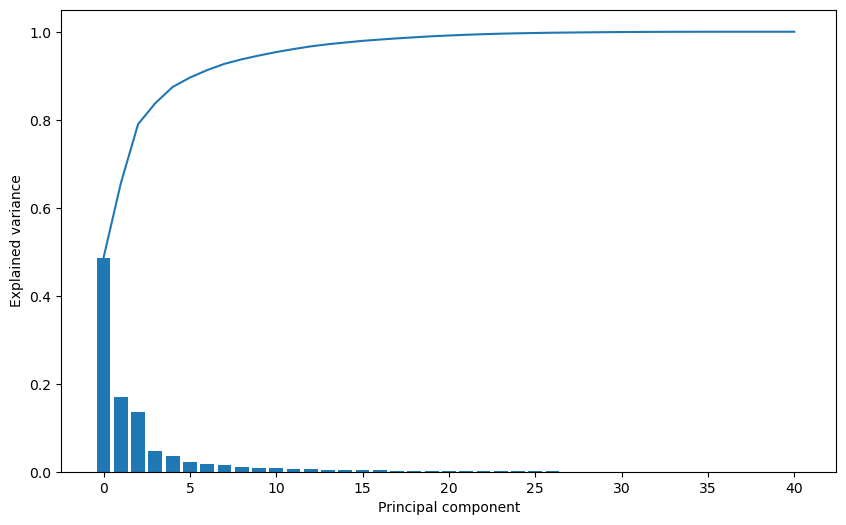

In [325]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])


num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
# plotto la cumulativa
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [326]:
# If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that 
# the amount of variance that needs to be explained is greater than the percentage specified by n_components. 
# default sdv_solver == 'auto'
pca = PCA(n_components=0.95, svd_solver = 'full')
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

#### Concateno

In [327]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1) # PCA
# dataset_norm = np.concatenate((X_norm, y_norm), axis=1) # NO PCA

# print(X_pca.shape)
print(dataset_norm.shape)

(16032, 12)


In [335]:
# Utilizziamo tutte le 24 ore precedenti per predirre le 24 successive
past_history = 24
future_target = 24

In [336]:
X_train, y_train = multivariate_data(dataset_norm[:,:-1], dataset_norm[:,-1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=False)

In [337]:
X_val, y_val = multivariate_data(dataset_norm[:,:-1], dataset_norm[:,-1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=False)

In [352]:
X_test, y_test = multivariate_data(dataset_norm[:,:-1], dataset_norm[:,-1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=False)

In [353]:
X_test.shape

(3158, 24, 11)

In [339]:
batch_size = 64

# Creo un dataset  accoppiando per riga i tensori X e y
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().batch(batch_size).prefetch(1) #La funzione cache() memorizza in cache i dati per accelerare il caricamento successivo

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [340]:
# Define some common parameters
input_shape = X_train.shape[-2:]
print(input_shape)

loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30)

(24, 11)


In [311]:
y_test_inversi = []
num_zone = y_test.shape[-1]
for zona in range(num_zone):
    y_test_dim = y_test[:, :, zona]
    y_test_dim_inv = y_sc.inverse_transform(y_test_dim)
    y_test_inversi.append(y_test_dim_inv)

# y_test_inversi conterrà le versioni invertite per ciascuna zona


In [361]:
df.columns

Index(['PUN', 'CALA', 'CNOR', 'CSUD', 'NORD', 'SARD', 'SICI', 'SUD', 'Totale',
       'CALA_stima', 'CNOR_stima', 'CSUD_stima', 'NORD_stima', 'SARD_stima',
       'SICI_stima', 'SUD_stima', 'GAS', 'TOTALE_ACQUISTI', 'CALA_ACQUISTI',
       'CNOR_ACQUISTI', 'CSUD_ACQUISTI', 'NORD_ACQUISTI', 'SARD_ACQUISTI',
       'SICI_ACQUISTI', 'SUD_ACQUISTI', 'TOTALE_VENDITE', 'CALA_VENDITE',
       'CNOR_VENDITE', 'CSUD_VENDITE', 'NORD_VENDITE', 'SARD_VENDITE',
       'SICI_VENDITE', 'SUD_VENDITE', 'Mese', 'GiornoSettimana', 'Weekend',
       'Ora', 'Total_Load', 'P_7', 'P_14', 'GAS_AHEAD'],
      dtype='object')

In [362]:
y_test_inv = y_sc.inverse_transform(y_test)

In [314]:
len(y_test)
y_test.shape

(3158, 24, 8)

## Forecasting

### LSTM FOR EVERY ZONE

#### CALA

In [238]:
X = zone_dataframes['CALA'].values
y = zone_dataframes['CALA']['CALA'].values

y = y.reshape(-1, 1)

In [227]:
# Utilizzo due scaler diversi per evitare bias
X_sc = MinMaxScaler(feature_range=(0, 1))
y_sc = MinMaxScaler(feature_range=(0, 1))

# fitto gli scaler ai miei dati
X_sc.fit(X[:train_end_idx])
y_sc.fit(y[:train_end_idx])

# Rinormalizzo
X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)

In [230]:
dataset_norm = np.concatenate((X_norm, y_norm), axis=1) 


In [234]:
X_train, y_train = multivariate_data(dataset_norm[:,:-1], dataset_norm[:,-1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=False)

In [235]:
X_val, y_val = multivariate_data(dataset_norm[:,:-1], dataset_norm[:,-1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=False)

In [248]:
X_test, y_test = multivariate_data(dataset_norm[:,:-1], dataset_norm[:,-1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=False)

In [239]:
batch_size = 64

# Creo un dataset  accoppiando per riga i tensori X e y
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().batch(batch_size).prefetch(1) #La funzione cache() memorizza in cache i dati per accelerare il caricamento successivo

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

# Define some common parameters
input_shape = X_train.shape[-2:]
print(input_shape)

loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30)

y_test_inv = y_sc.inverse_transform(y_test) 


(24, 13)


In [240]:
tf.keras.backend.clear_session()
multivariate_lstm_zone = tf.keras.models.Sequential()

In [241]:
multivariate_lstm_zone.add(LSTM(64, input_shape=input_shape, return_sequences=True)) 
multivariate_lstm_zone.add(Dropout(0.2))
multivariate_lstm_zone.add(LSTM(32, input_shape=input_shape))
multivariate_lstm_zone.add(Flatten())
multivariate_lstm_zone.add(Dense(future_target, activation='relu'))
multivariate_lstm_zone.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            19968     
                                                                 
 dropout (Dropout)           (None, 24, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
Total params: 33176 (129.59 KB)
Trainable params: 33176 (129.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [242]:
# Callback per il salvataggio del modello
lstm_checkpoint_zone = ModelCheckpoint('multivariate_lstm_2_layers.h5', monitor='val_loss', save_best_only=True)

multivariate_lstm_zone.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
# Vuole questa metrica altrimenti fa capricci con la stringa

Epoch 1/70


150/150 [==============================] - 12s 42ms/step - loss: 0.0224 - root_mean_squared_error: 0.1495 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 2/70
  1/150 [..............................] - ETA: 5s - loss: 0.0097 - root_mean_squared_error: 0.0987

c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 5s 37ms/step - loss: 0.0204 - root_mean_squared_error: 0.1429 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 3/70
150/150 [==============================] - 7s 44ms/step - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0630
Epoch 4/70
150/150 [==============================] - 6s 38ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0525
Epoch 5/70
150/150 [==============================] - 6s 38ms/step - loss: 0.0212 - root_mean_squared_error: 0.1457 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 6/70
150/150 [==============================] - 6s 40ms/step - loss: 0.0183 - root_mean_squared_error: 0.1354 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 7/70
150/150 [==============================] - 6s 37ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.0033 - val_root_

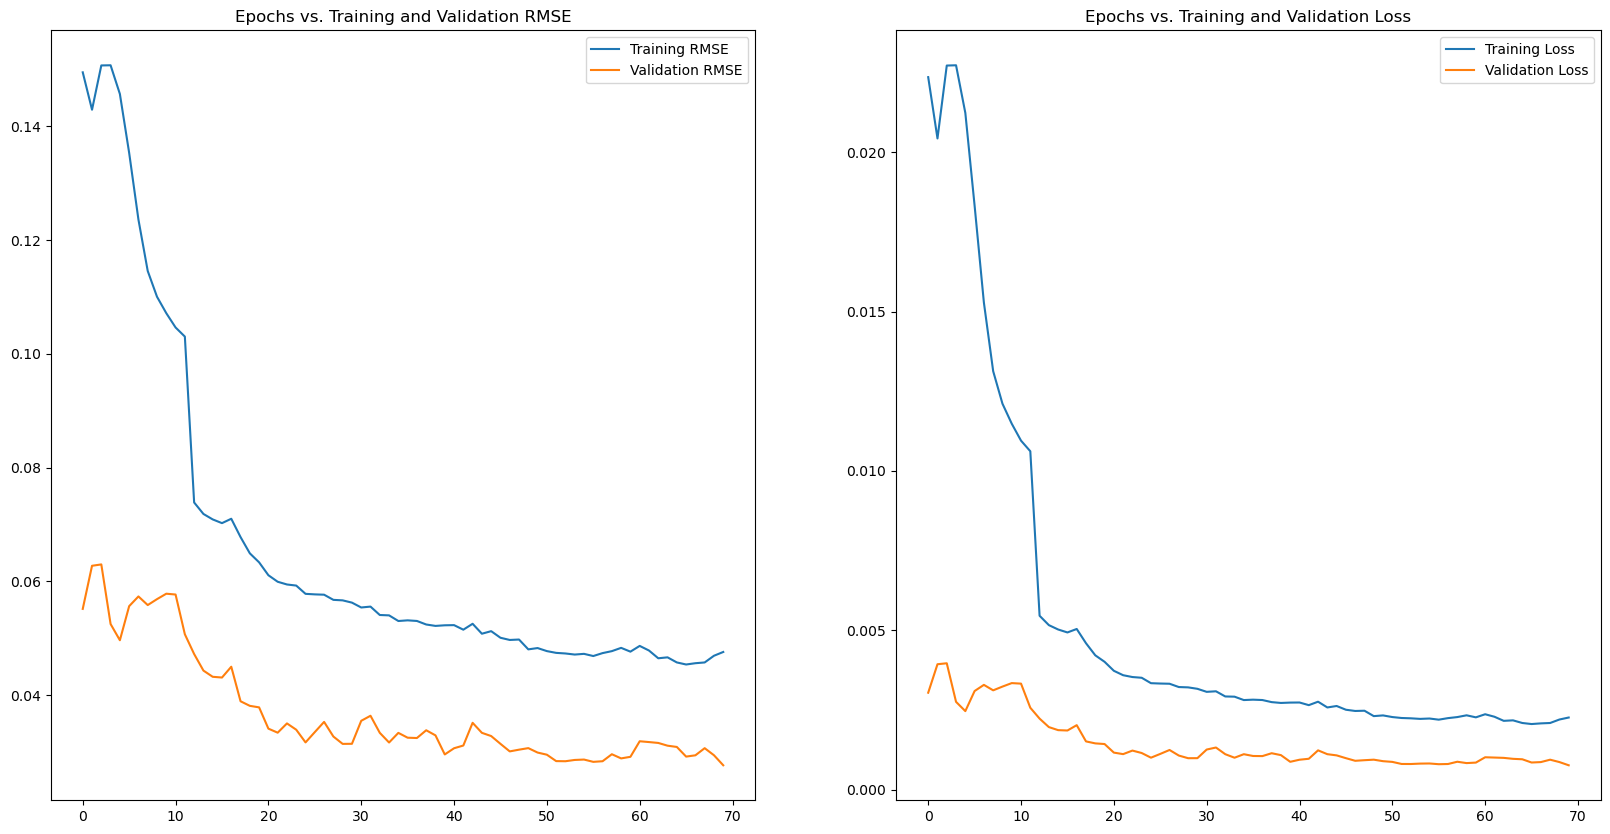

ValueError: in user code:

    File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py", line 2357, in predict_step
        return self(x, training=False)
    File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 24, 43), found shape=(None, 24, 13)


In [243]:
history = multivariate_lstm_zone.fit(train, epochs=70, verbose=1,
                                validation_data=validation,
                                callbacks=[ 
                                           lstm_checkpoint])


plot_model_rmse_and_loss(history)

# multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')


(3158, 24)

 1/99 [..............................] - ETA: 3s

99/99 [==============================] - 1s 9ms/step
Evaluation metric results:
MSE is : 824.1987732585793
MAE is : 22.3259339733317
RMSE is : 28.582344412535623
MAPE is : inf
NMAE is : 0.18446283022353915



C:\Users\Giova\AppData\Local\Temp\ipykernel_10740\2131772969.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Giova\AppData\Local\Temp\ipykernel_10740\2131772969.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Giova\AppData\Local\Temp\ipykernel_10740\2131772969.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Giova\AppData\Local\Temp\ipykernel_10740\2131772969.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Giova\AppData\Local\Temp\ipykernel_10740\2131772969.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Giova\AppData\Local\Temp\ipykernel_10740\2131772969.py:4: RuntimeWarning: divide by zero encount

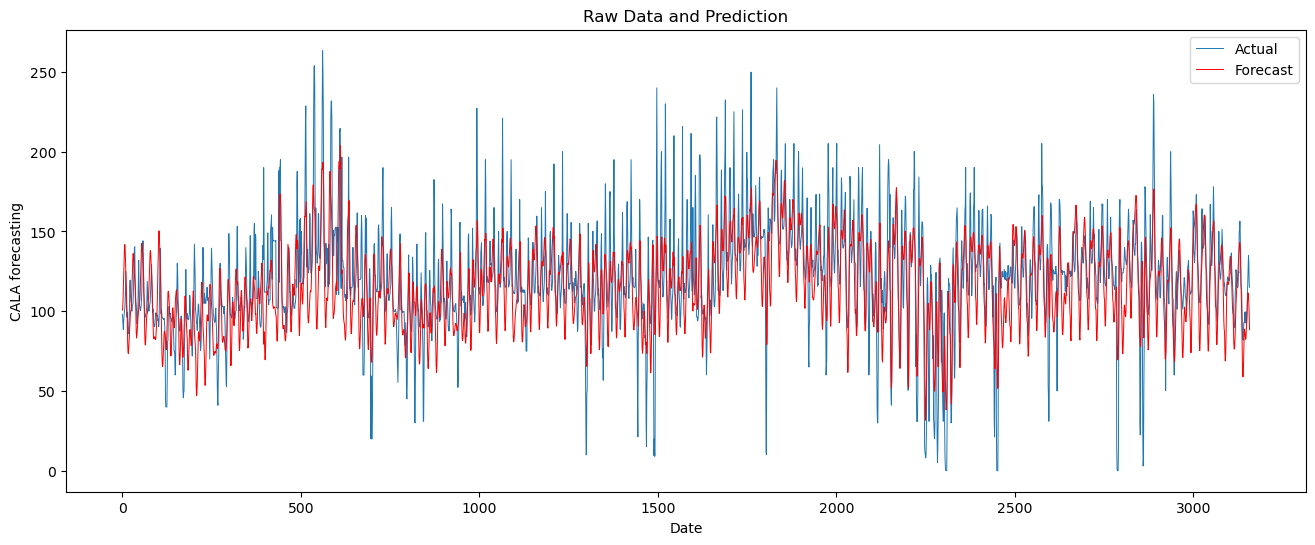

In [250]:
forecast = multivariate_lstm_zone.predict(X_test)
lstm_forecast = y_sc.inverse_transform(forecast)

timeseries_evaluation_metrics_func(y_test_inv, lstm_forecast)

# A visual representation
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv[:,0], linewidth=0.7, label='Actual')
plt.plot(lstm_forecast[:,0], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('CALA forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

#### For every zone

In [289]:
def train_multivariate_lstm(dataset_norm, past_history, future_target, train_end_idx, cv_end_idx, test_end_idx):
    X_train, y_train = multivariate_data(dataset_norm[:,:-1], dataset_norm[:,-1],
                                         0, train_end_idx, past_history, 
                                         future_target, step=1, single_step=False)
    X_val, y_val = multivariate_data(dataset_norm[:,:-1], dataset_norm[:,-1],
                                     train_end_idx, cv_end_idx, past_history, 
                                     future_target, step=1, single_step=False)
    X_test, y_test = multivariate_data(dataset_norm[:,:-1], dataset_norm[:,-1],
                                       cv_end_idx, test_end_idx, past_history, 
                                       future_target, step=1, single_step=False)

    batch_size = 64

    # Creo un dataset  accoppiando per riga i tensori X e y
    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train = train.cache().batch(batch_size).prefetch(1)

    validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    validation = validation.batch(batch_size).prefetch(1)

    # Define some common parameters
    input_shape = X_train.shape[-2:]

    loss = tf.keras.losses.MeanSquaredError()
    metric = [tf.keras.metrics.RootMeanSquaredError()]

    tf.keras.backend.clear_session()
    multivariate_lstm = tf.keras.models.Sequential()
    multivariate_lstm.add(LSTM(64, input_shape=input_shape, return_sequences=True)) 
    multivariate_lstm.add(Dropout(0.2))
    multivariate_lstm.add(LSTM(32, input_shape=input_shape))
    multivariate_lstm.add(Flatten())
    multivariate_lstm.add(Dense(future_target, activation='relu'))

    # Callback per il salvataggio del modello
    lstm_checkpoint = ModelCheckpoint('multivariate_lstm.h5', monitor='val_loss', save_best_only=True)

    multivariate_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

    # Addestramento del modello
    history = multivariate_lstm.fit(train, epochs=70, verbose=3,
                                    validation_data=validation,
                                    callbacks=[lstm_checkpoint])

    # Carica il modello migliore durante l'addestramento
    multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

    # Esegui previsioni sul set di test
    forecast = multivariate_lstm.predict(X_test)
    lstm_forecast = y_sc.inverse_transform(forecast)

    # Valuta le prestazioni del modello
    y_test_inv = y_sc.inverse_transform(y_test)
    timeseries_evaluation_metrics_func(y_test_inv, lstm_forecast)

    # Visualizzazione delle previsioni
    plt.figure(figsize=(16, 6))
    plt.plot(y_test_inv[:,0], linewidth=0.7, label='Actual')
    plt.plot(lstm_forecast[:,0], linewidth=0.7, color='r', label='Forecast')

    plt.xlabel('Date')
    plt.ylabel('PUN forecasting')
    plt.title('Raw Data and Prediction')
    plt.legend()
    plt.show()

    return multivariate_lstm, history, lstm_forecast


In [290]:
nan_counts_func(zone_dataframes['SUD'])

Nessun valore NaN nel DataFrame.


Training model for CALA...
Epoch 1/70
Epoch 2/70


c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/70
Epoch 4/70
Epoch 5/70
Epoch 6/70
Epoch 7/70
Epoch 8/70
Epoch 9/70
Epoch 10/70
Epoch 11/70
Epoch 12/70
Epoch 13/70
Epoch 14/70
Epoch 15/70
Epoch 16/70
Epoch 17/70
Epoch 18/70
Epoch 19/70
Epoch 20/70
Epoch 21/70
Epoch 22/70
Epoch 23/70
Epoch 24/70
Epoch 25/70
Epoch 26/70
Epoch 27/70
Epoch 28/70
Epoch 29/70
Epoch 30/70
Epoch 31/70
Epoch 32/70
Epoch 33/70
Epoch 34/70
Epoch 35/70
Epoch 36/70
Epoch 37/70
Epoch 38/70
Epoch 39/70
Epoch 40/70
Epoch 41/70
Epoch 42/70
Epoch 43/70
Epoch 44/70
Epoch 45/70
Epoch 46/70
Epoch 47/70
Epoch 48/70
Epoch 49/70
Epoch 50/70
Epoch 51/70
Epoch 52/70
Epoch 53/70
Epoch 54/70
Epoch 55/70
Epoch 56/70
Epoch 57/70
Epoch 58/70
Epoch 59/70
Epoch 60/70
Epoch 61/70
Epoch 62/70
Epoch 63/70
Epoch 64/70
Epoch 65/70
Epoch 66/70
Epoch 67/70
Epoch 68/70
Epoch 69/70
Epoch 70/70
97/97 [==============================] - 5s 30ms/step
Evaluation metric results:
MSE is : 779.239184539187
MAE is : 20.70580262944367
RMSE is : 27.84787635424114
MAPE is : 1406.5016429433836


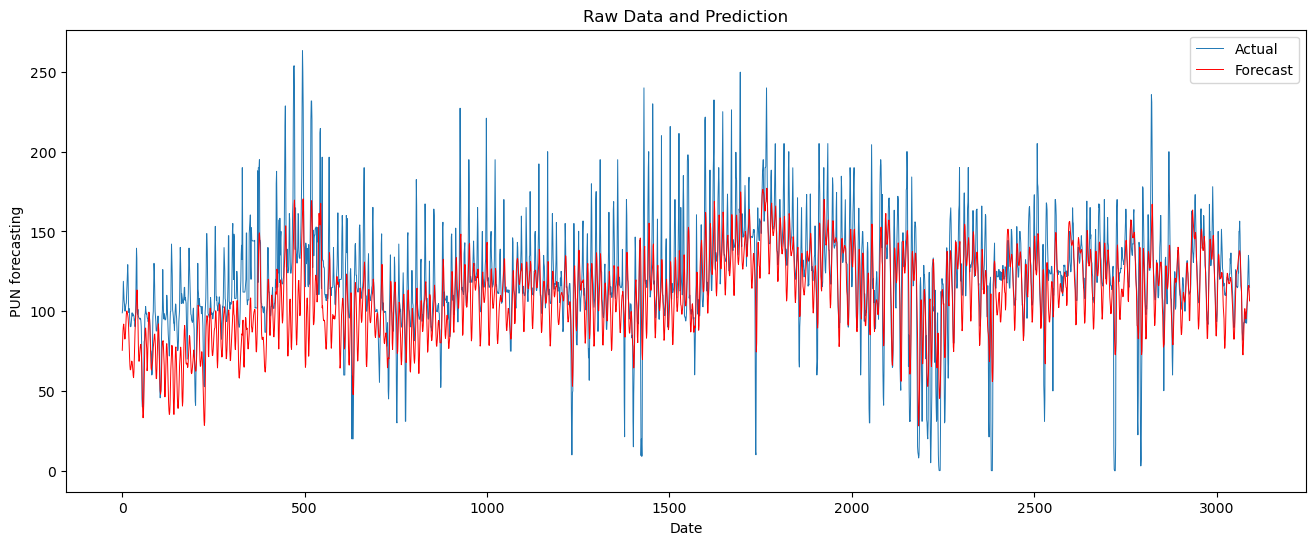

Training model for CNOR...
Epoch 1/70
Epoch 2/70


c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/70
Epoch 4/70
Epoch 5/70
Epoch 6/70
Epoch 7/70
Epoch 8/70
Epoch 9/70
Epoch 10/70
Epoch 11/70
Epoch 12/70
Epoch 13/70
Epoch 14/70
Epoch 15/70
Epoch 16/70
Epoch 17/70
Epoch 18/70
Epoch 19/70
Epoch 20/70
Epoch 21/70
Epoch 22/70
Epoch 23/70
Epoch 24/70
Epoch 25/70
Epoch 26/70
Epoch 27/70
Epoch 28/70
Epoch 29/70
Epoch 30/70
Epoch 31/70
Epoch 32/70
Epoch 33/70
Epoch 34/70
Epoch 35/70
Epoch 36/70
Epoch 37/70
Epoch 38/70
Epoch 39/70
Epoch 40/70
Epoch 41/70
Epoch 42/70
Epoch 43/70
Epoch 44/70
Epoch 45/70
Epoch 46/70
Epoch 47/70
Epoch 48/70
Epoch 49/70
Epoch 50/70
Epoch 51/70
Epoch 52/70
Epoch 53/70
Epoch 54/70
Epoch 55/70
Epoch 56/70
Epoch 57/70
Epoch 58/70
Epoch 59/70
Epoch 60/70
Epoch 61/70
Epoch 62/70
Epoch 63/70
Epoch 64/70
Epoch 65/70
Epoch 66/70
Epoch 67/70
Epoch 68/70
Epoch 69/70
Epoch 70/70
97/97 [==============================] - 2s 8ms/step
Evaluation metric results:
MSE is : 920.5330497657792
MAE is : 23.185700626293073
RMSE is : 29.704906549097146
MAPE is : 27.97206581298996

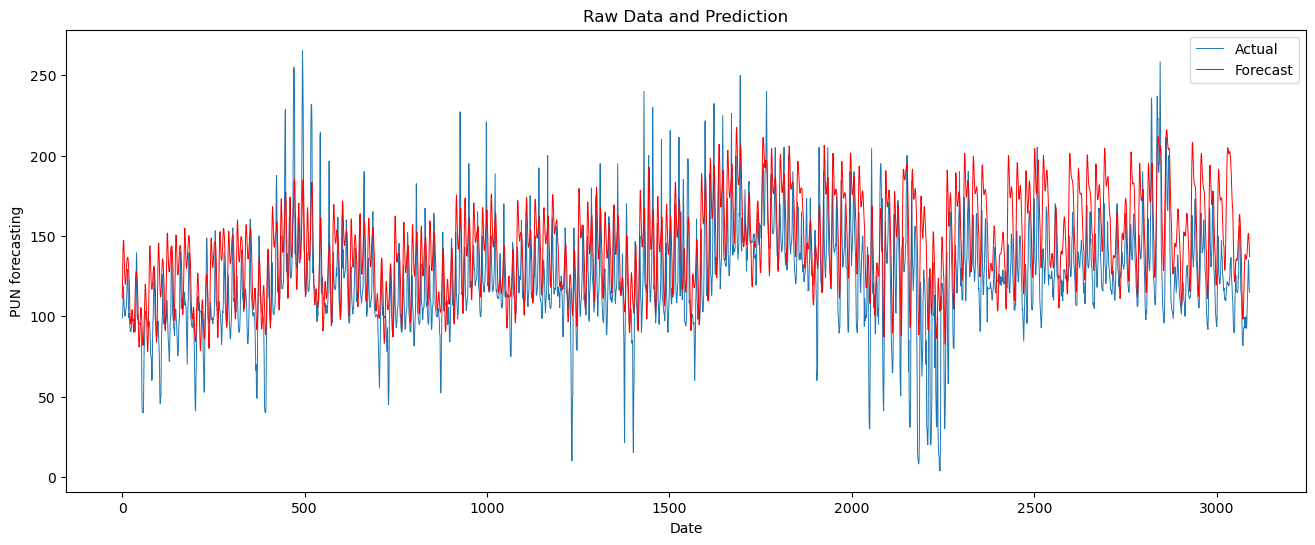

Training model for CSUD...
Epoch 1/70
Epoch 2/70


c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/70
Epoch 4/70
Epoch 5/70
Epoch 6/70
Epoch 7/70
Epoch 8/70
Epoch 9/70
Epoch 10/70
Epoch 11/70
Epoch 12/70
Epoch 13/70
Epoch 14/70
Epoch 15/70
Epoch 16/70
Epoch 17/70
Epoch 18/70
Epoch 19/70
Epoch 20/70
Epoch 21/70
Epoch 22/70
Epoch 23/70
Epoch 24/70
Epoch 25/70
Epoch 26/70
Epoch 27/70
Epoch 28/70
Epoch 29/70
Epoch 30/70
Epoch 31/70
Epoch 32/70
Epoch 33/70
Epoch 34/70
Epoch 35/70
Epoch 36/70
Epoch 37/70
Epoch 38/70
Epoch 39/70
Epoch 40/70
Epoch 41/70
Epoch 42/70
Epoch 43/70
Epoch 44/70
Epoch 45/70
Epoch 46/70
Epoch 47/70
Epoch 48/70
Epoch 49/70
Epoch 50/70
Epoch 51/70
Epoch 52/70
Epoch 53/70
Epoch 54/70
Epoch 55/70
Epoch 56/70
Epoch 57/70
Epoch 58/70
Epoch 59/70
Epoch 60/70
Epoch 61/70
Epoch 62/70
Epoch 63/70
Epoch 64/70
Epoch 65/70
Epoch 66/70
Epoch 67/70
Epoch 68/70
Epoch 69/70
Epoch 70/70
97/97 [==============================] - 3s 12ms/step
Evaluation metric results:
MSE is : 798.1195320158336
MAE is : 21.36401004542377
RMSE is : 28.07274565127496
MAPE is : 867.4756371903208


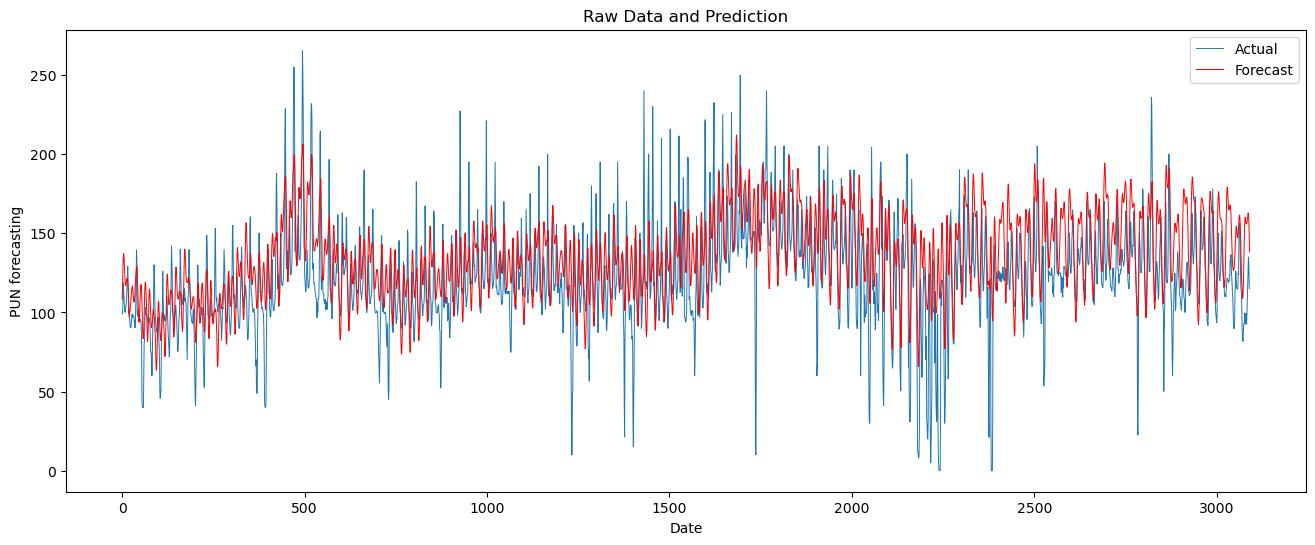

Training model for NORD...
Epoch 1/70
Epoch 2/70


c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/70
Epoch 4/70
Epoch 5/70
Epoch 6/70
Epoch 7/70
Epoch 8/70
Epoch 9/70
Epoch 10/70
Epoch 11/70
Epoch 12/70
Epoch 13/70
Epoch 14/70
Epoch 15/70
Epoch 16/70
Epoch 17/70
Epoch 18/70
Epoch 19/70
Epoch 20/70
Epoch 21/70
Epoch 22/70
Epoch 23/70
Epoch 24/70
Epoch 25/70
Epoch 26/70
Epoch 27/70
Epoch 28/70
Epoch 29/70
Epoch 30/70
Epoch 31/70
Epoch 32/70
Epoch 33/70
Epoch 34/70
Epoch 35/70
Epoch 36/70
Epoch 37/70
Epoch 38/70
Epoch 39/70
Epoch 40/70
Epoch 41/70
Epoch 42/70
Epoch 43/70
Epoch 44/70
Epoch 45/70
Epoch 46/70
Epoch 47/70
Epoch 48/70
Epoch 49/70
Epoch 50/70
Epoch 51/70
Epoch 52/70
Epoch 53/70
Epoch 54/70
Epoch 55/70
Epoch 56/70
Epoch 57/70
Epoch 58/70
Epoch 59/70
Epoch 60/70
Epoch 61/70
Epoch 62/70
Epoch 63/70
Epoch 64/70
Epoch 65/70
Epoch 66/70
Epoch 67/70
Epoch 68/70
Epoch 69/70
Epoch 70/70
97/97 [==============================] - 2s 7ms/step
Evaluation metric results:
MSE is : 637.6275232557759
MAE is : 18.627120624183515
RMSE is : 25.23160310521875
MAPE is : 22.68210829645825


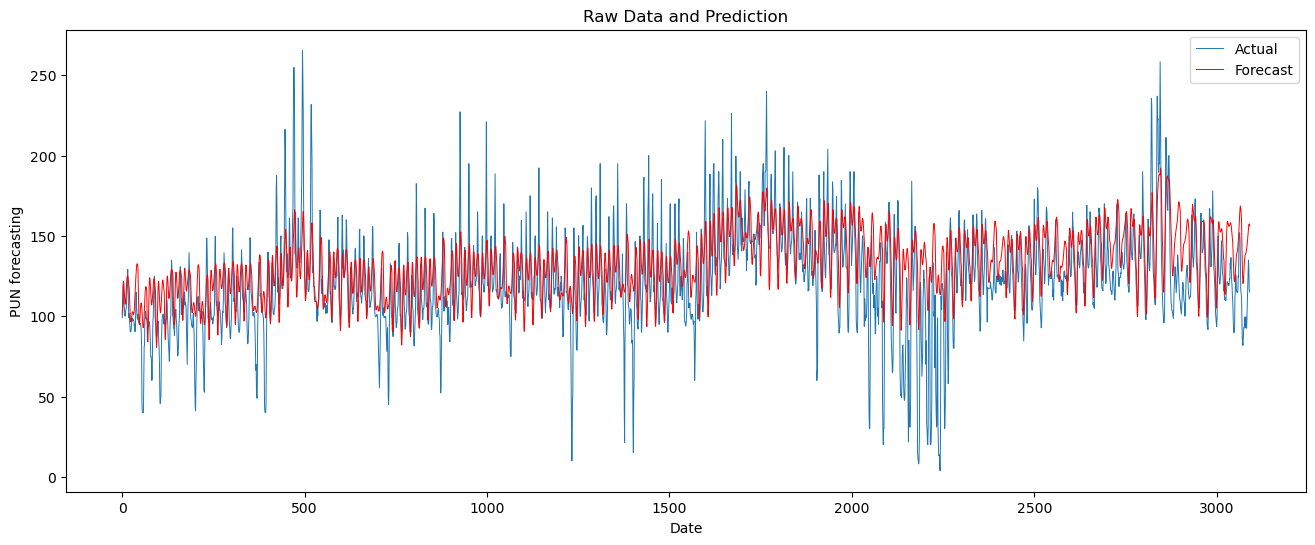

Training model for SARD...
Epoch 1/70
Epoch 2/70


c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/70
Epoch 4/70
Epoch 5/70
Epoch 6/70
Epoch 7/70
Epoch 8/70
Epoch 9/70
Epoch 10/70
Epoch 11/70
Epoch 12/70
Epoch 13/70
Epoch 14/70
Epoch 15/70
Epoch 16/70
Epoch 17/70
Epoch 18/70
Epoch 19/70
Epoch 20/70
Epoch 21/70
Epoch 22/70
Epoch 23/70
Epoch 24/70
Epoch 25/70
Epoch 26/70
Epoch 27/70
Epoch 28/70
Epoch 29/70
Epoch 30/70
Epoch 31/70
Epoch 32/70
Epoch 33/70
Epoch 34/70
Epoch 35/70
Epoch 36/70
Epoch 37/70
Epoch 38/70
Epoch 39/70
Epoch 40/70
Epoch 41/70
Epoch 42/70
Epoch 43/70
Epoch 44/70
Epoch 45/70
Epoch 46/70
Epoch 47/70
Epoch 48/70
Epoch 49/70
Epoch 50/70
Epoch 51/70
Epoch 52/70
Epoch 53/70
Epoch 54/70
Epoch 55/70
Epoch 56/70
Epoch 57/70
Epoch 58/70
Epoch 59/70
Epoch 60/70
Epoch 61/70
Epoch 62/70
Epoch 63/70
Epoch 64/70
Epoch 65/70
Epoch 66/70
Epoch 67/70
Epoch 68/70
Epoch 69/70
Epoch 70/70
97/97 [==============================] - 2s 8ms/step
Evaluation metric results:
MSE is : 991.4861643215245
MAE is : 23.479447266362342
RMSE is : 31.383091054629077
MAPE is : 661.0914447653321

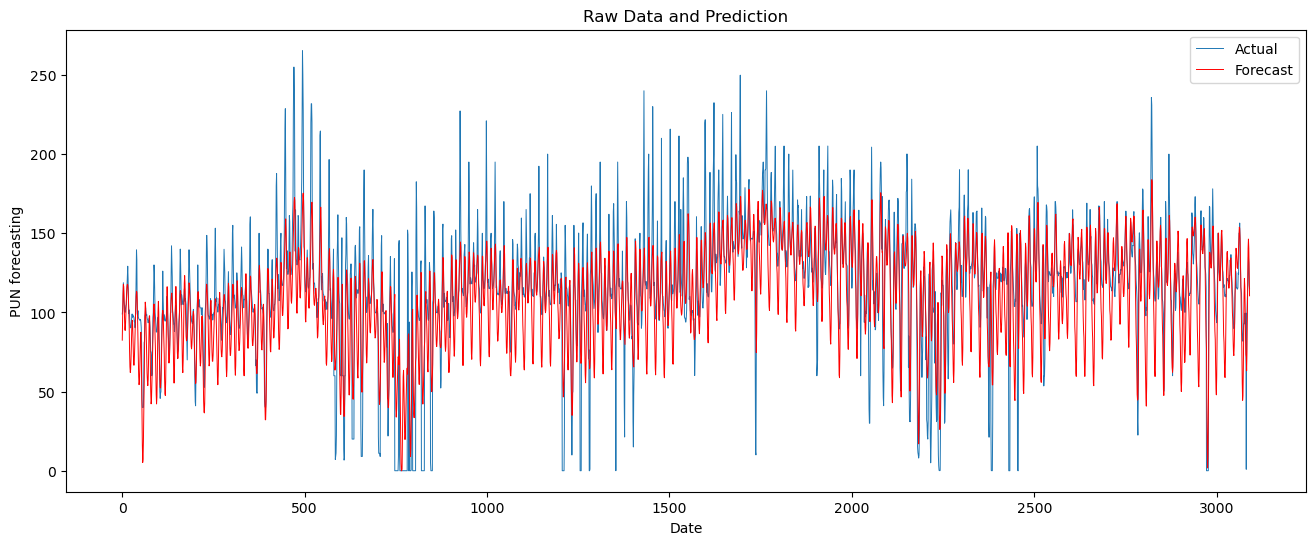

Training model for SICI...
Epoch 1/70
Epoch 2/70


c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/70
Epoch 4/70
Epoch 5/70
Epoch 6/70
Epoch 7/70
Epoch 8/70
Epoch 9/70
Epoch 10/70
Epoch 11/70
Epoch 12/70
Epoch 13/70
Epoch 14/70
Epoch 15/70
Epoch 16/70
Epoch 17/70
Epoch 18/70
Epoch 19/70
Epoch 20/70
Epoch 21/70
Epoch 22/70
Epoch 23/70
Epoch 24/70
Epoch 25/70
Epoch 26/70
Epoch 27/70
Epoch 28/70
Epoch 29/70
Epoch 30/70
Epoch 31/70
Epoch 32/70
Epoch 33/70
Epoch 34/70
Epoch 35/70
Epoch 36/70
Epoch 37/70
Epoch 38/70
Epoch 39/70
Epoch 40/70
Epoch 41/70
Epoch 42/70
Epoch 43/70
Epoch 44/70
Epoch 45/70
Epoch 46/70
Epoch 47/70
Epoch 48/70
Epoch 49/70
Epoch 50/70
Epoch 51/70
Epoch 52/70
Epoch 53/70
Epoch 54/70
Epoch 55/70
Epoch 56/70
Epoch 57/70
Epoch 58/70
Epoch 59/70
Epoch 60/70
Epoch 61/70
Epoch 62/70
Epoch 63/70
Epoch 64/70
Epoch 65/70
Epoch 66/70
Epoch 67/70
Epoch 68/70
Epoch 69/70
Epoch 70/70
97/97 [==============================] - 2s 7ms/step
Evaluation metric results:
MSE is : 1031.6986264643508
MAE is : 24.62767098742653
RMSE is : 32.022793992799386
MAPE is : 1501.743634069083

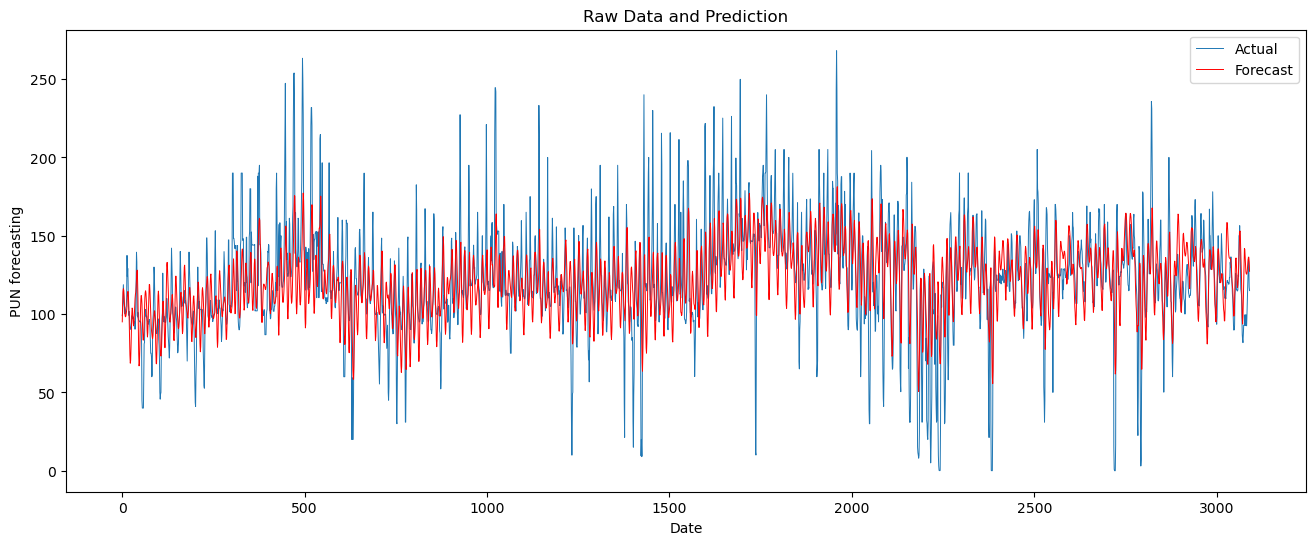

Training model for SUD...
Epoch 1/70
Epoch 2/70


c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/70
Epoch 4/70
Epoch 5/70
Epoch 6/70
Epoch 7/70
Epoch 8/70
Epoch 9/70
Epoch 10/70
Epoch 11/70
Epoch 12/70
Epoch 13/70
Epoch 14/70
Epoch 15/70
Epoch 16/70
Epoch 17/70
Epoch 18/70
Epoch 19/70
Epoch 20/70
Epoch 21/70
Epoch 22/70
Epoch 23/70
Epoch 24/70
Epoch 25/70
Epoch 26/70
Epoch 27/70
Epoch 28/70
Epoch 29/70
Epoch 30/70
Epoch 31/70
Epoch 32/70
Epoch 33/70
Epoch 34/70
Epoch 35/70
Epoch 36/70
Epoch 37/70
Epoch 38/70
Epoch 39/70
Epoch 40/70
Epoch 41/70
Epoch 42/70
Epoch 43/70
Epoch 44/70
Epoch 45/70
Epoch 46/70
Epoch 47/70
Epoch 48/70
Epoch 49/70
Epoch 50/70
Epoch 51/70
Epoch 52/70
Epoch 53/70
Epoch 54/70
Epoch 55/70
Epoch 56/70
Epoch 57/70
Epoch 58/70
Epoch 59/70
Epoch 60/70
Epoch 61/70
Epoch 62/70
Epoch 63/70
Epoch 64/70
Epoch 65/70
Epoch 66/70
Epoch 67/70
Epoch 68/70
Epoch 69/70
Epoch 70/70
97/97 [==============================] - 2s 9ms/step
Evaluation metric results:
MSE is : 710.2310622936797
MAE is : 18.824269511805863
RMSE is : 26.587335604685933
MAPE is : 1595.074831173326

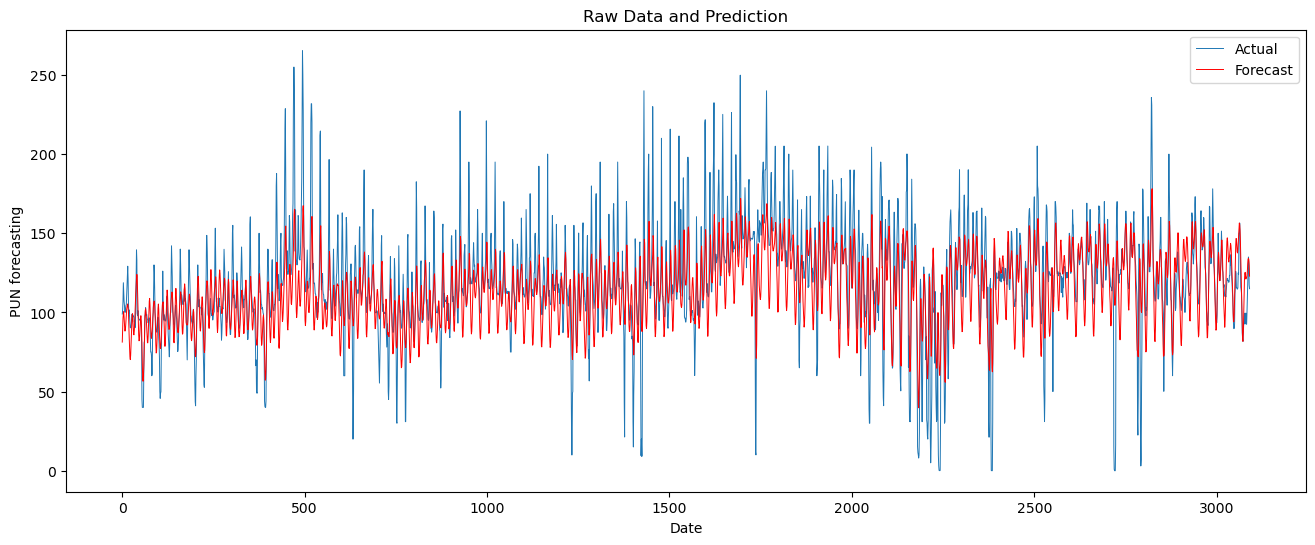

Training completed for all zones.


In [316]:
trained_models = []
training_histories = []
test_forecasts = []

for zona, zone_dataframe in zone_dataframes.items(): 
    print(f"Training model for {zona}...")
    
    X = zone_dataframe.values
    y = zone_dataframe[zona].values.reshape(-1, 1)

    # Utilizzo due scaler diversi per evitare bias
    X_sc = MinMaxScaler(feature_range=(0, 1))
    y_sc = MinMaxScaler(feature_range=(0, 1))

    # fitto gli scaler ai miei dati
    X_sc.fit(X[:train_end_idx])
    y_sc.fit(y[:train_end_idx])

    # Rinormalizzo
    X_norm = X_sc.transform(X)
    y_norm = y_sc.transform(y)

    dataset_norm = np.concatenate((X_norm, y_norm), axis=1)

    # Divisione in training, validation e test set
    train_end_idx = int(len(zone_dataframe[zona]) * 0.6)
    cv_end_idx = train_end_idx + int(len(zone_dataframe[zona]) * 0.2)
    test_end_idx = cv_end_idx + int(len(zone_dataframe[zona]) * 0.2)

    model, training_history, test_forecast = train_multivariate_lstm(dataset_norm, past_history, future_target, train_end_idx, cv_end_idx, test_end_idx)

    # Aggiungi il modello, le history ecc. alle rispettive liste
    trained_models.append(model)
    training_histories.append(training_history)
    test_forecasts.append(test_forecast)

print("Training completed for all zones.")


#### Failed try

In [ ]:
y_zo

In [372]:
# dataset_norm = np.concatenate((X_pca, y_norm), axis=1) # PCA
dataset_norm = np.concatenate((X_norm, y_zone_norm), axis=1) # NO PCA

# print(X_pca.shape)
print(dataset_norm.shape)
# Utilizziamo tutte le 24 ore precedenti per predirre le 24 successive
past_history = 24
future_target = 24


(16032, 49)


In [373]:
X_train, y_train = multivariate_data(dataset_norm[:,-9], dataset_norm[:,-9:-1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=False)
X_val, y_val = multivariate_data(dataset_norm[:,:-9], dataset_norm[:,-9:-1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=False)
X_test, y_test = multivariate_data(dataset_norm[:,:-9], dataset_norm[:,-9:-1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=False)
batch_size = 64

# Creo un dataset  accoppiando per riga i tensori X e y
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().batch(batch_size).prefetch(1) #La funzione cache() memorizza in cache i dati per accelerare il caricamento successivo

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)
# Define some common parameters
input_shape = X_train.shape[-2:]
print(input_shape)


(9571, 24)


In [ ]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30)
y_test_inversi = []
num_zone = y_test.shape[-1]
for zona in range(num_zone):
    y_test_dim = y_test[:, :, zona]
    y_test_dim_inv = y_sc.inverse_transform(y_test_dim)
    y_test_inversi.append(y_test_dim_inv)

# y_test_inversi conterrà le versioni invertite per ciascuna zona


In [201]:
tf.keras.backend.clear_session()
multivariate_lstm_zone = tf.keras.models.Sequential()
print(f'Input_shape is {input_shape}')
print(f'X_train_shape is {X_train.shape}')


multivariate_lstm_zone.add(LSTM(64, input_shape=input_shape, return_sequences=True)) 
multivariate_lstm_zone.add(Dropout(0.2))
multivariate_lstm_zone.add(LSTM(32, input_shape=input_shape))
multivariate_lstm_zone.add(Flatten())
multivariate_lstm_zone.add(Dense(future_target * num_zone , activation='relu'))
multivariate_lstm_zone.summary()


Input_shape is (24, 43)
X_train_shape is (9571, 24, 43)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            27648     
                                                                 
 dropout (Dropout)           (None, 24, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
Total params: 40328 (157.53 KB)
Trainable params: 40328 (157.53 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________

In [202]:
# Callback per il salvataggio del modello
zone_lstm_checkpoint = ModelCheckpoint('multivariate_lstm_zone.h5', monitor='val_loss', save_best_only=True)

multivariate_lstm_zone.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
# Vuole questa metrica altrimenti fa capricci con la stringa


In [203]:
history = multivariate_lstm_zone.fit(train, epochs=30, verbose=1,
                                validation_data=validation,
                                callbacks=[lstm_checkpoint])

plot_model_rmse_and_loss(history)

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\Giova\anaconda3_new\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\Giova\anaconda3_new\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\Giova\anaconda3_new\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Giova\AppData\Local\Temp\ipykernel_10740\1728204954.py", line 1, in <module>

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py", line 1130, in train_step

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\optimizers\optimizer.py", line 543, in minimize

  File "c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\optimizers\optimizer.py", line 276, in compute_gradients

Incompatible shapes: [64,8] vs. [64,24,8]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_325516]

In [ ]:
# multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm_zone.predict(X_test)
lstm_forecast = y_sc.inverse_transform(forecast)

timeseries_evaluation_metrics_func(y_test_inv, lstm_forecast)

# A visual representation
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv[:,0], linewidth=0.7, label='Actual')
plt.plot(lstm_forecast[:,0], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

### LSTM

In [342]:
tf.keras.backend.clear_session()
multivariate_lstm = tf.keras.models.Sequential()

In [286]:
print(f'Input_shape is {input_shape}')
print(f'X_train_shape is {X_train.shape}')

Input_shape is (24, 13)
X_train_shape is (9571, 24, 13)


In [287]:
multivariate_lstm.add(LSTM(64, input_shape=input_shape, return_sequences=True)) 
multivariate_lstm.add(Dropout(0.2))
multivariate_lstm.add(LSTM(32, input_shape=input_shape))
multivariate_lstm.add(Flatten())
multivariate_lstm.add(Dense(future_target, activation='relu'))
multivariate_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            19968     
                                                                 
 dropout (Dropout)           (None, 24, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
Total params: 33176 (129.59 KB)
Trainable params: 33176 (129.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [288]:
# Callback per il salvataggio del modello
lstm_checkpoint = ModelCheckpoint('multivariate_lstm_2_layers.h5', monitor='val_loss', save_best_only=True)

multivariate_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
# Vuole questa metrica altrimenti fa capricci con la stringa

In [106]:
history = multivariate_lstm.fit(train, epochs=90, verbose=1,
                                validation_data=validation,
                                callbacks=[ 
                                           lstm_checkpoint])


Epoch 1/90
150/150 [==============================] - 17s 61ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 2/90
  1/150 [..............................] - ETA: 6s - loss: 0.0060 - root_mean_squared_error: 0.0773

c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 6s 43ms/step - loss: 0.0207 - root_mean_squared_error: 0.1438 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 3/90
150/150 [==============================] - 7s 46ms/step - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0768
Epoch 4/90
150/150 [==============================] - 6s 43ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 5/90
150/150 [==============================] - 7s 44ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 6/90
150/150 [==============================] - 7s 44ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 7/90
150/150 [==============================] - 6s 42ms/step - loss: 0.0184 - root_mean_squared_error: 0.1355 - val_loss: 0.0016 - val_root_

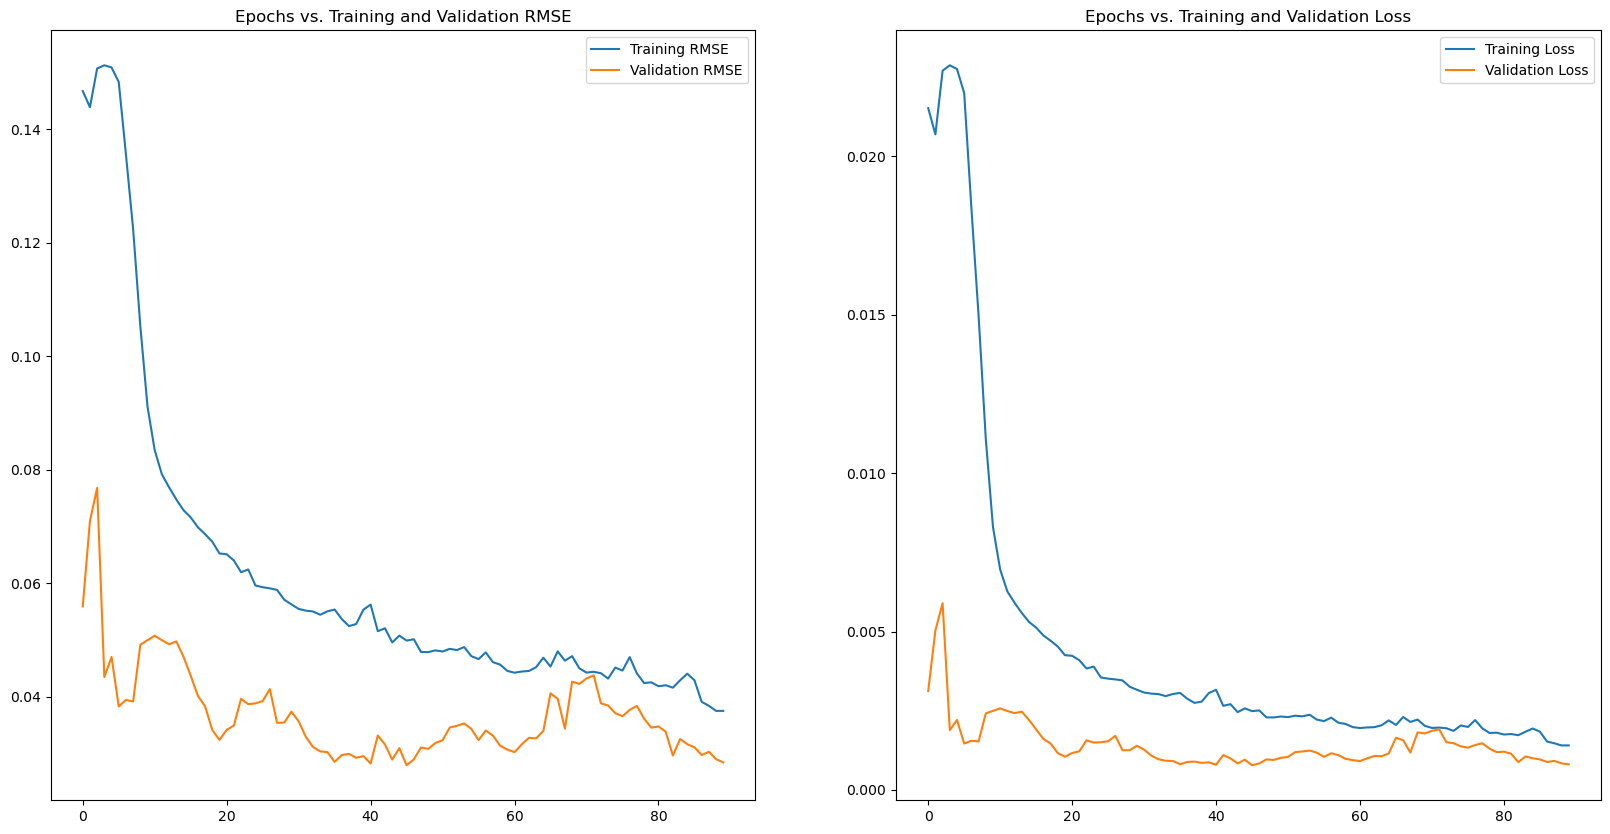

In [107]:
plot_model_rmse_and_loss(history)

99/99 [==============================] - 5s 16ms/step
Evaluation metric results:
MSE is : 605.3306677348073
MAE is : 18.485409964452142
RMSE is : 24.562201159578848
MAPE is : 22.82908885213287
NMAE is : 0.15243484842365493



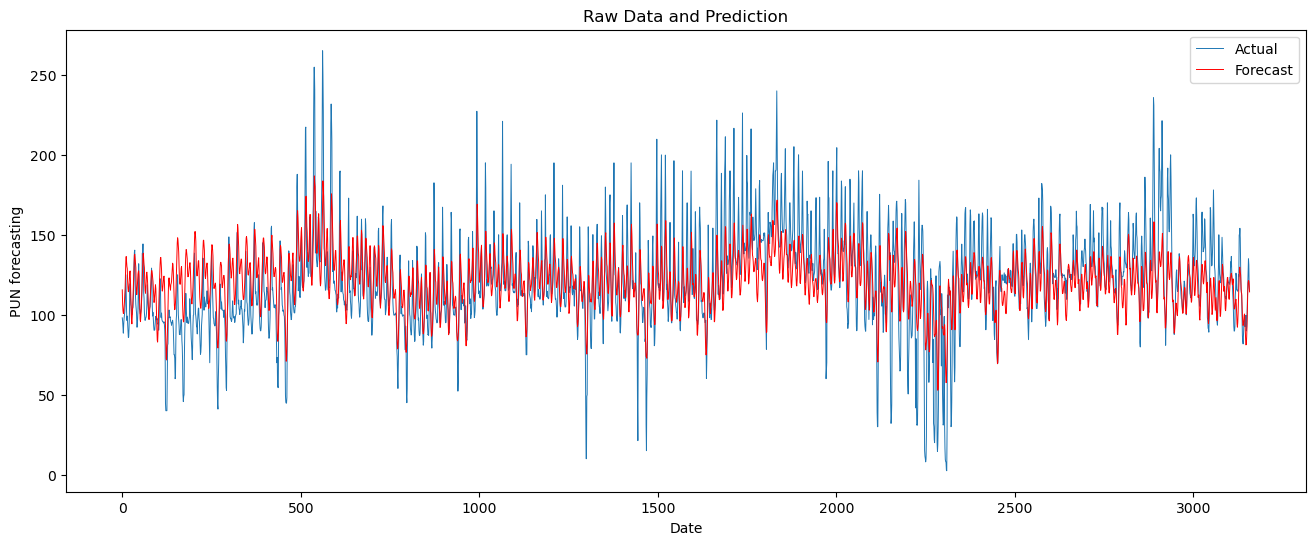

In [108]:
# multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = y_sc.inverse_transform(forecast)

timeseries_evaluation_metrics_func(y_test_inv, lstm_forecast)

# A visual representation
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv[:,0], linewidth=0.7, label='Actual')
plt.plot(lstm_forecast[:,0], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

In [660]:
# Evaluation metric results con il PUN:-
# MSE is : 442.5260895652706
# MAE is : 15.239669588324091
# RMSE is : 21.03630408520638
# MAPE is : 18.356657415679386
# NMAE is : 0.12968583618107182

In [ ]:
# Evaluation metric results:-
# MSE is : 315.1267387248029
# MAE is : 13.9005773695072
# RMSE is : 17.751809449315385
# MAPE is : 16.006332189084553
# NMAE is : 0.11412249189493587

In [536]:
# Evaluation metric results with no PCA:-
# MSE is : 454.20999239764893
# MAE is : 16.575698420646763
# RMSE is : 21.312202898753778
# MAPE is : 25.404349139023886
# NMAE is : 0.1486527564928474

In [ ]:
# Evaluation metric results with PCA:
# MSE is : 410.98451204626826
# MAE is : 15.549762464772167
# RMSE is : 20.272752946905566
# MAPE is : 25.48222186986722
# NMAE is : 0.1394520456717626

### CNN-LSTM

In [357]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=6,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    MaxPooling1D(2),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    Flatten(),
    Dense(30, activation='relu'),
    Dense(future_target)
])

In [358]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm_norelu.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

Epoch 1/90


150/150 [==============================] - 6s 18ms/step - loss: 0.0138 - root_mean_squared_error: 0.1036 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 2/90
  6/150 [>.............................] - ETA: 1s - loss: 0.0042 - root_mean_squared_error: 0.0645

c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 2s 14ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 3/90
150/150 [==============================] - 2s 14ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 4/90
150/150 [==============================] - 2s 14ms/step - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0495
Epoch 5/90
150/150 [==============================] - 2s 13ms/step - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0519
Epoch 6/90
150/150 [==============================] - 2s 14ms/step - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 7/90
150/150 [==============================] - 2s 14ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0021 - val_root_

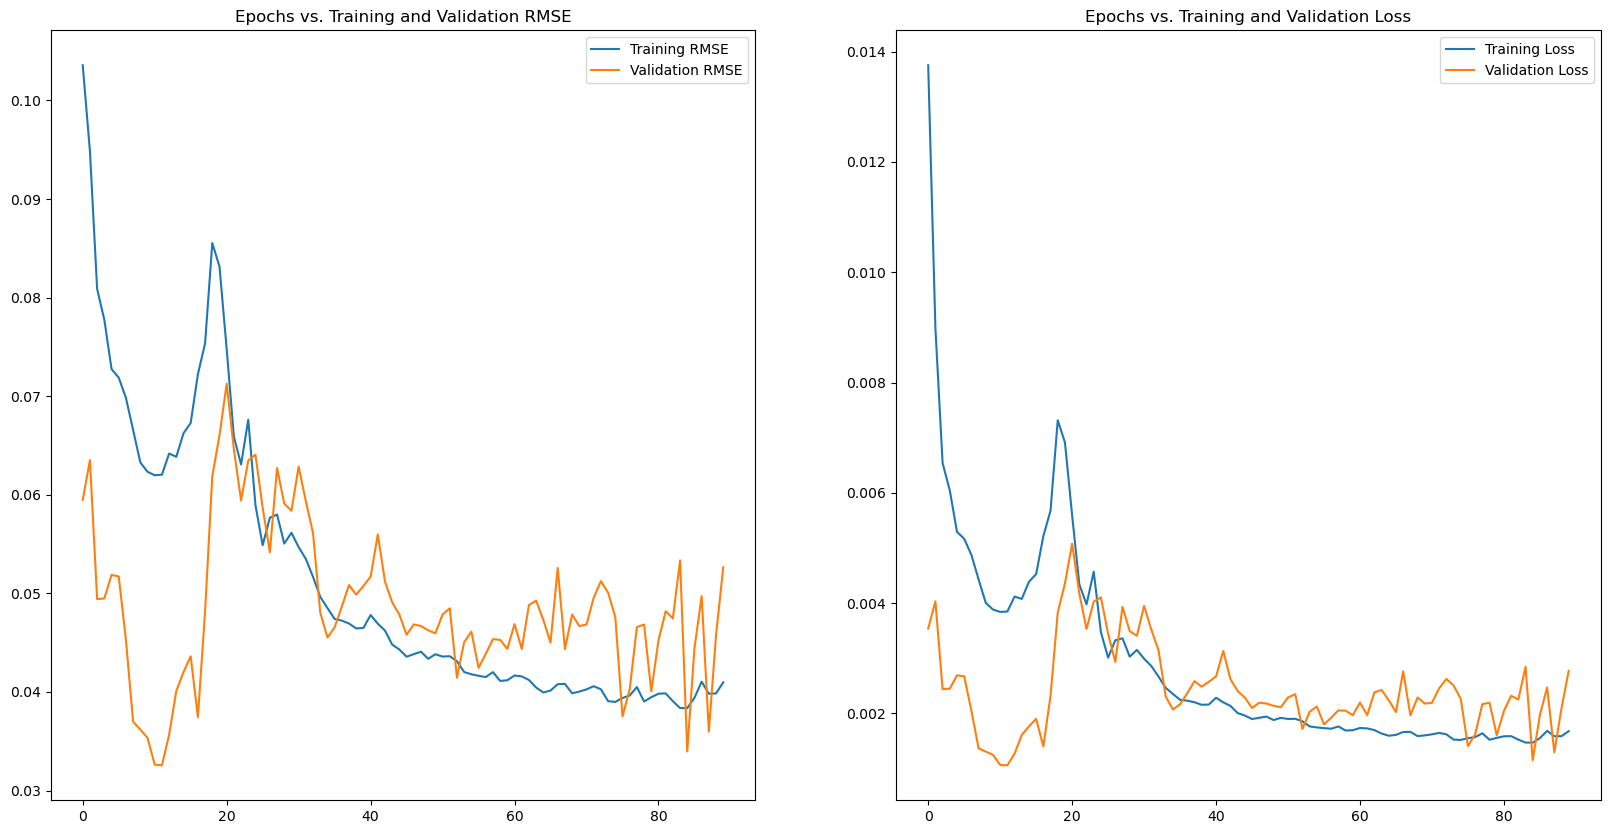

In [359]:
# !pip install pydot
# !pip install graphviz
# tf.keras.utils.plot_model(multivariate_cnn_lstm, show_shapes=True)

history = multivariate_cnn_lstm.fit(train, epochs=90,
                                    validation_data=validation,
                                    callbacks=[
                                               model_checkpoint])

                                               
plot_model_rmse_and_loss(history)

# multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')


In [355]:
X_val.shape

(3158, 24, 11)

99/99 [==============================] - 1s 4ms/step
Evaluation metric results:
MSE is : 6308.049172145448
MAE is : 72.58604253491899
RMSE is : 78.3635448463612
MAPE is : 76.86944572588041
NMAE is : 0.5985186635551202



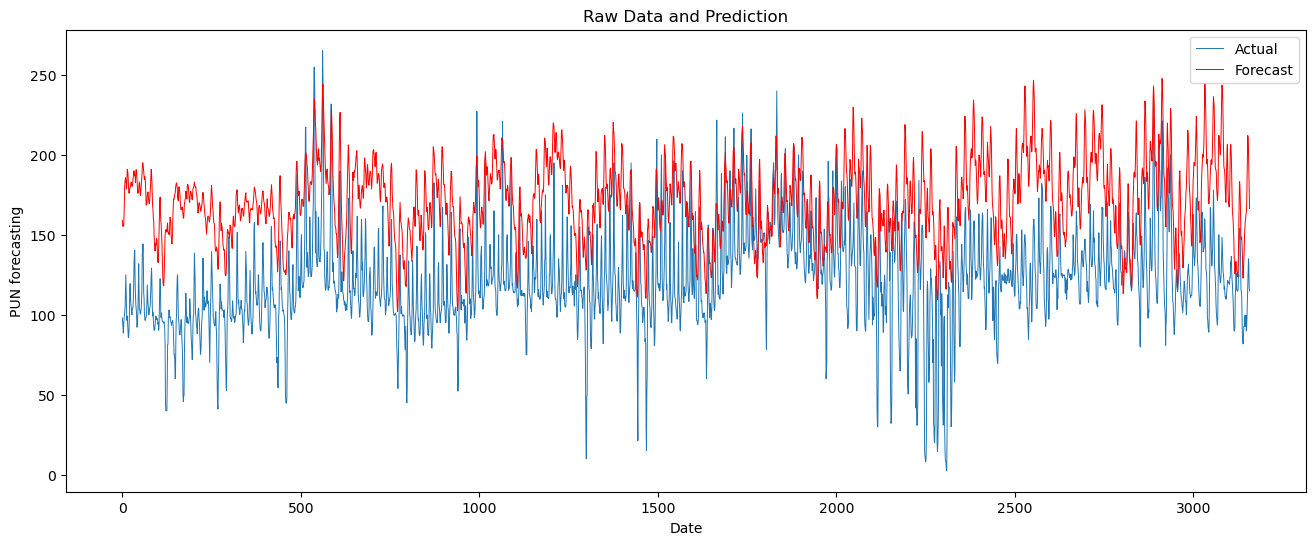

In [360]:

forecast = multivariate_cnn_lstm.predict(X_test)
lstm_forecast = y_sc.inverse_transform(forecast)

timeseries_evaluation_metrics_func(y_test_inv, lstm_forecast)

# A visual representation
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv[:,0], linewidth=0.7, label='Actual')
plt.plot(lstm_forecast[:,0], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

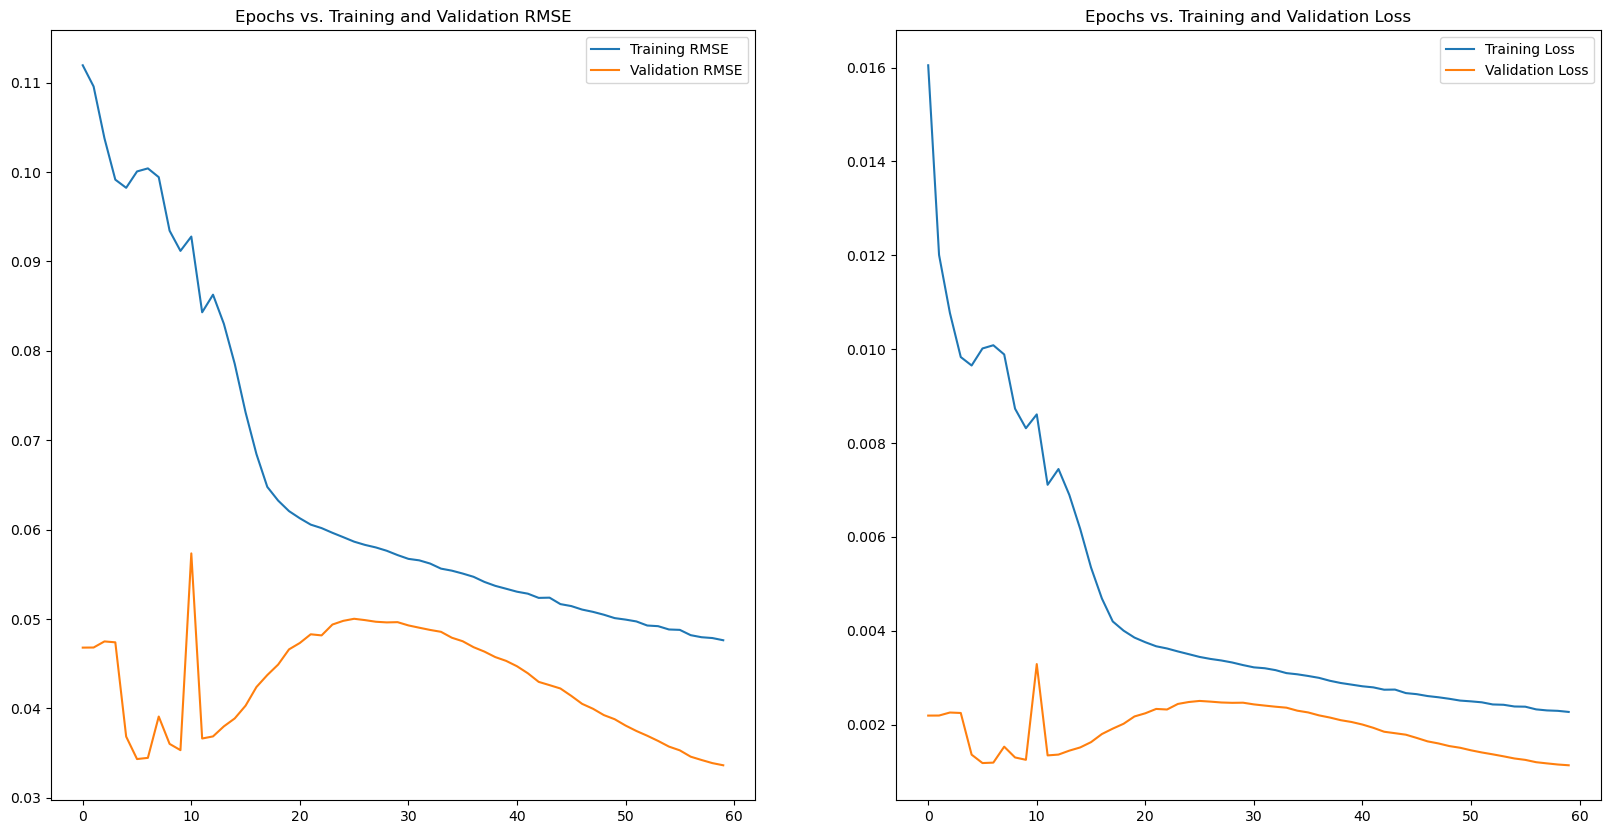

In [121]:
# multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm_norelu.h5')


forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = y_sc.inverse_transform(forecast)

99/99 [==============================] - 2s 6ms/step


Evaluation metric results:
MSE is : 892.7566026524877
MAE is : 24.007034493118795
RMSE is : 29.841256804320818
MAPE is : 29.669536699106953
NMAE is : 0.19796636694210412



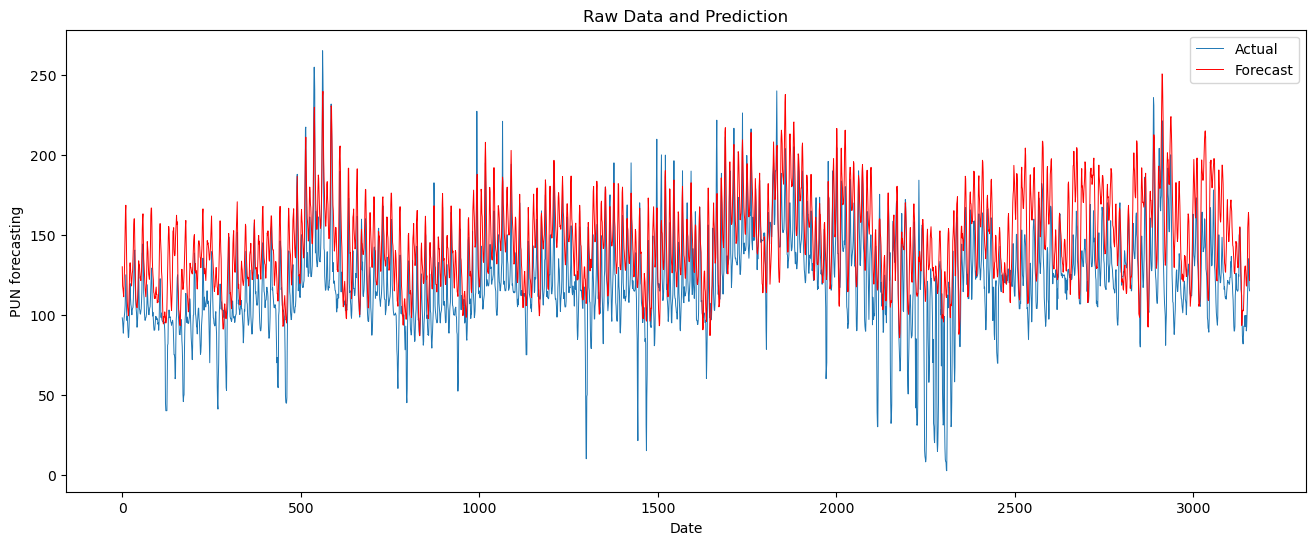

In [122]:
timeseries_evaluation_metrics_func(y_test_inv, multivariate_cnn_lstm_forecast)

# A visual representation
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv[:,0], linewidth=0.7, label='Actual')
plt.plot(multivariate_cnn_lstm_forecast[:,0], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

### XGBoost

In [123]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

#### hyperparameter search

In [737]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb_model = XGBRegressor()


param_grid = {
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'max_depth': [5, 10, 20, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1],
    'gamma': [0, 0.1, 0.5, 1],
    'min_child_weight': [1, 5, 10]
}


random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,  # Numero di combinazioni casuali da provare
    scoring='neg_mean_squared_error',  # La metrica da ottimizzare
    cv=3,  # Numero di fold nella cross-validation
    verbose=2,  # Verbosità
    n_jobs=-1  # Utilizza tutti i core della CPU disponibili
)

In [739]:
y_train_xgb = y_train.reshape(-1, y_train.shape[1] * y_train.shape[2])


# Addestra il modello sulla griglia degli iperparametri
random_search.fit(X_train_xgb, y_train_xgb)

# Stampa i migliori iperparametri trovati
print("Best Hyperparameters:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:

# Predici utilizzando il modello con i migliori iperparametri
forecast_best_params = random_search.best_estimator_.predict(X_test_xgb)

# Inverti la trasformazione per ottenere previsioni non normalizzate
forecast_best_params_inv = y_sc.inverse_transform(forecast_best_params)

# Visualizza i risultati
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv[:, 0], linewidth=0.7, label='Actual')
plt.plot(forecast_best_params_inv[:3091, 0], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction (Best Hyperparameters)')
plt.legend()
plt.show()

# Calcola e stampa le metriche di valutazione
timeseries_evaluation_metrics_func(y_test_inv[:, 0], forecast_best_params_inv[:3091, 0])


#### random parameters

In [124]:
param = {'eta': 0.03, 'max_depth': 180, 
         'subsample': 1.0, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)

eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 150, eval_list, early_stopping_rounds=3)

c:\Users\Giova\anaconda3_new\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\Giova\anaconda3_new\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:11:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\Giova\anaconda3_new\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:11:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.15483	eval-rmse:0.19305
[1]	train-rmse:0.15055	eval-rmse:0.18775
[2]	train-rmse:0.14642	eval-rmse:0.18254
[3]	train-rmse:0.14241	eval-rmse:0.17757
[4]	train-rmse:0.13853	eval-rmse:0.17274
[5]	train-rmse:0.13477	eval-rmse:0.16798
[6]	train-rmse:0.13114	eval-rmse:0.16344
[7]	train-rmse:0.12762	eval-rmse:0.15903
[8]	train-rmse:0.12421	eval-rmse:0.15480
[9]	train-rmse:0.12092	eval-rmse:0.15066
[10]	train-rmse:0.11773	eval-rmse:0.14672
[11]	train-rmse:0.11464	eval-rmse:0.14291
[12]	train-rmse:0.11165	eval-rmse:0.13922
[13]	train-rmse:0.10875	eval-rmse:0.13565
[14]	train-rmse:0.10595	eval-rmse:0.13217
[15]	train-rmse:0.10324	eval-rmse:0.12881
[16]	train-rmse:0.10062	eval-rmse:0.12557
[17]	train-rmse:0.09809	eval-rmse:0.12241
[18]	train-rmse:0.09564	eval-rmse:0.11934
[19]	train-rmse:0.09327	eval-rmse:0.11641
[20]	train-rmse:0.09098	eval-rmse:0.11360
[21]	train-rmse:0.08876	eval-rmse:0.11083
[22]	train-rmse:0.08663	eval-rmse:0.10811
[23]	train-rmse:0.08456	eval-rmse:0.10548
[2

In [125]:
forecast = xgb_model.predict(dtest)
# xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = y_sc.inverse_transform(forecast)


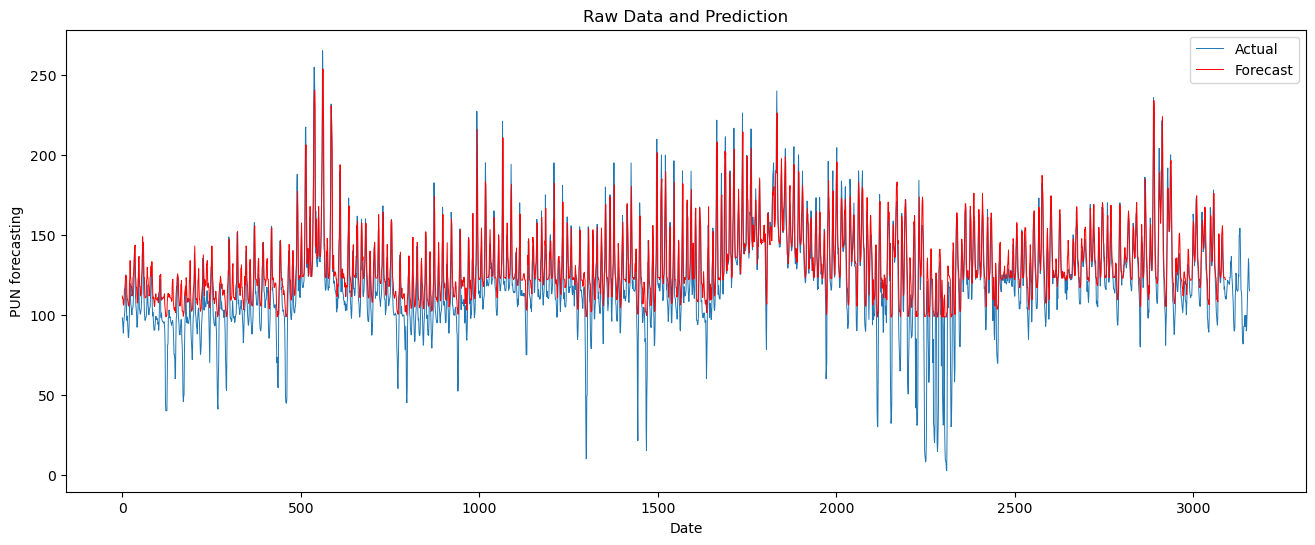

In [126]:
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv[:,0], linewidth=0.7, label='Actual')
plt.plot(xgb_forecast_inv[:3091,0], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

In [129]:
timeseries_evaluation_metrics_func(y_test_inv, xgb_forecast_inv)

Evaluation metric results:
MSE is : 627.3950950997804
MAE is : 18.61433423224899
RMSE is : 24.99613984524758
MAPE is : 26.890096296648426
NMAE is : 0.1534945903772314



In [ ]:
# Con PCA, non rerunnare
# timeseries_evaluation_metrics_func(y_test_inv[:,0], xgb_forecast_inv[:331,0])

### Univariate

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [131]:
# Definisci una funzione per preparare i dati
def prepare_data(data, history_size=72, target_size=24):
    X, y = [], []
    for i in range(len(data) - history_size - target_size + 1):
        X.append(data[i:i+history_size])
        y.append(data[i+history_size:i+history_size+target_size])
    return np.array(X), np.array(y)



In [132]:
data = df['PUN'].values.reshape(-1, 1)

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [133]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [134]:
history_size = 24
target_size = 24

X_train, y_train = prepare_data(train_data_scaled, history_size=history_size, target_size=target_size)
X_test, y_test = prepare_data(test_data_scaled, history_size=history_size, target_size=target_size)

In [135]:
# LSTM network expects the input data(X) to be [samples, time steps, features] format
y_train.shape[1] # ore da prevedere

24

In [144]:
tf.keras.backend.clear_session()

# Crea il modello LSTM
model = tf.keras.Sequential()
# return_sequences: Boolean. Whether to return the last output in the output sequence, 
# or the full sequence. Default: False.
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))  # Output layer ha un neurone per ogni ora da prevedere


In [145]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=70, batch_size=50)

# A batch of data is a fixed-sized number of rows from the training dataset that defines
# how many patterns to process before updating the weights of the network

Epoch 1/70
256/256 [==============================] - 20s 42ms/step - loss: 0.0092
Epoch 2/70
256/256 [==============================] - 12s 48ms/step - loss: 0.0043
Epoch 3/70
256/256 [==============================] - 12s 49ms/step - loss: 0.0041
Epoch 4/70
256/256 [==============================] - 12s 46ms/step - loss: 0.0040
Epoch 5/70
256/256 [==============================] - 11s 42ms/step - loss: 0.0040
Epoch 6/70
256/256 [==============================] - 11s 41ms/step - loss: 0.0037
Epoch 7/70
256/256 [==============================] - 10s 39ms/step - loss: 0.0035
Epoch 8/70
256/256 [==============================] - 11s 44ms/step - loss: 0.0032
Epoch 9/70
256/256 [==============================] - 11s 45ms/step - loss: 0.0029
Epoch 10/70
256/256 [==============================] - 10s 40ms/step - loss: 0.0028
Epoch 11/70
256/256 [==============================] - 10s 41ms/step - loss: 0.0027
Epoch 12/70
256/256 [==============================] - 11s 41ms/step - loss: 0.0027
E

In [146]:
# Valuta il modello
loss = model.evaluate(X_test, y_test)
print(f'Errore quadratico medio: {loss}')

# Fai previsioni per il test set
predictions = model.predict(X_test)

# Denormalizza le previsioni
predictions = scaler.inverse_transform(predictions)


99/99 [==============================] - 3s 12ms/step - loss: 4.9703e-04
Errore quadratico medio: 0.0004970349255017936
99/99 [==============================] - 3s 12ms/step


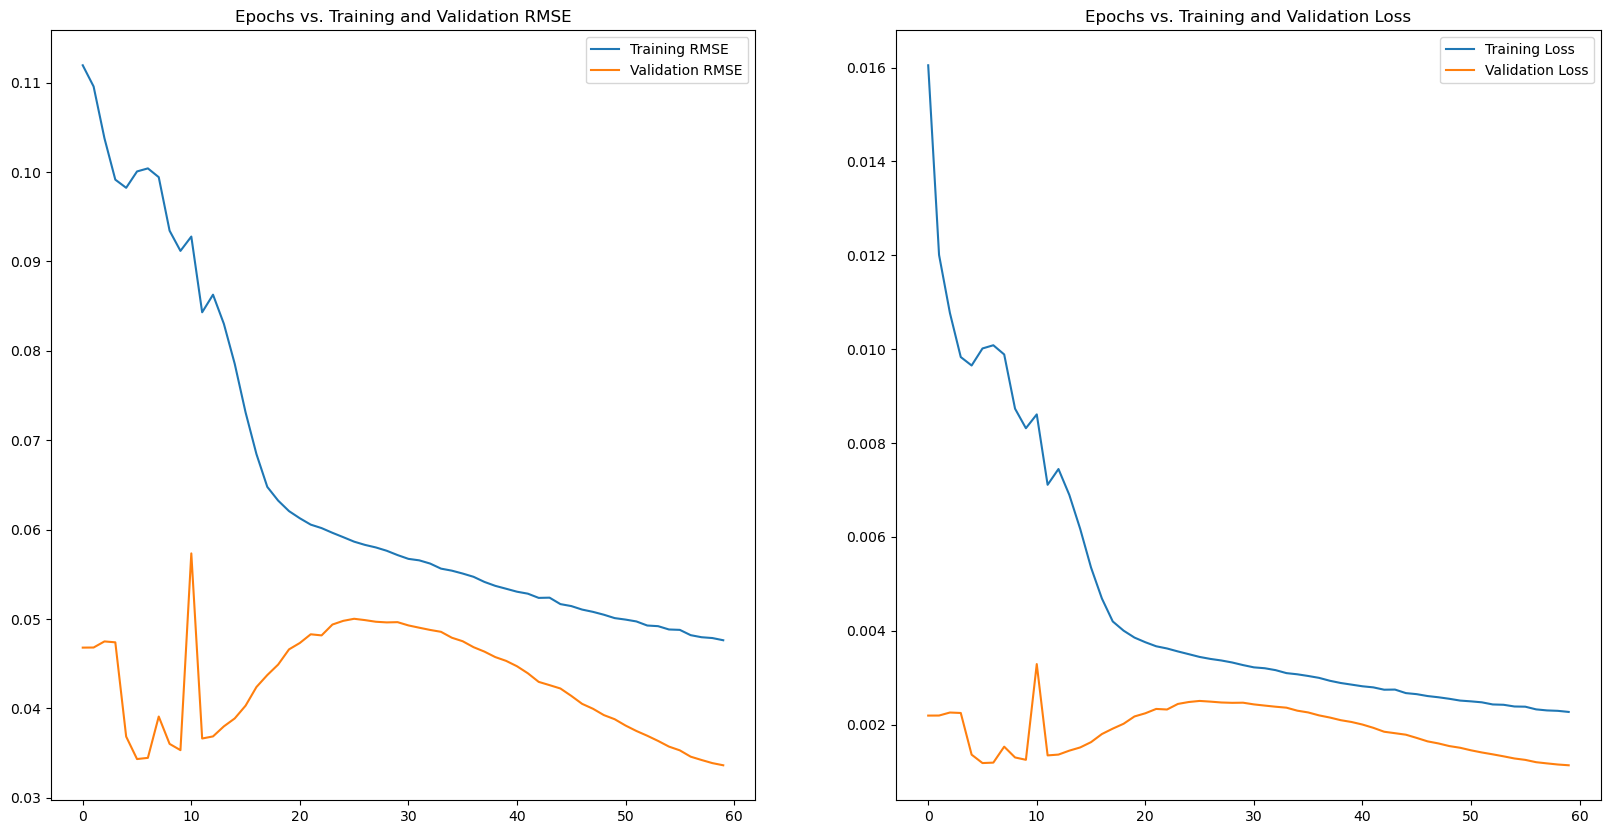

In [147]:
plot_model_rmse_and_loss(history)

In [148]:
predicted_pun = predictions[:, 0]
real_pun = test_data[:, 0]


single_timeseries_evaluation_metrics_func(predicted_pun[:3045], real_pun[:3045])

Evaluation metric results:-
MSE is : 351.44838423343066
MAE is : 13.47491771804484
RMSE is : 18.746956665907955
MAPE is : 11.49586757830247
NMAE is : 0.10753030595933155


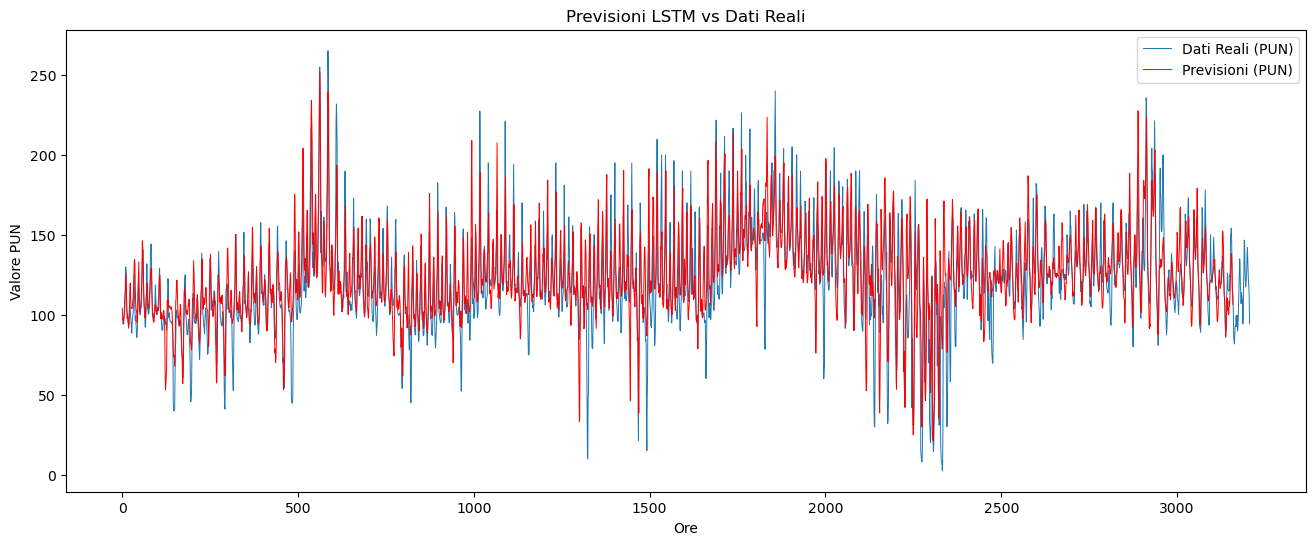

In [150]:
hours = df['Ora'].iloc[-len(X_test):].values
hours_plot = np.arange(len(X_test))

plt.figure(figsize=(16, 6))
plt.plot(real_pun, label='Dati Reali (PUN)', linewidth=0.7)
plt.plot(hours_plot, predicted_pun, label='Previsioni (PUN)', color='r', linewidth=0.7)
plt.xlabel('Ore')
plt.ylabel('Valore PUN')
plt.title('Previsioni LSTM vs Dati Reali')
plt.legend()
plt.show()




## IMPEMENTING A CLASS

In [ ]:
# Esempio dumb di creazione di una windows col metodo già implementato in tf

dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.window(5, shift=1, drop_remainder=True)
print(dataset)
# Per prevenire al seguente errore
# TypeError: '_VariantDataset' object is not subscriptable
# In sostanza appiattisce il dataset e mappa la funzione data in finestre di 5 batch
dataset = dataset.flat_map(lambda window: window.batch(5))
print(dataset)
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

for X, y in dataset:
    print("Input:", X.numpy(), "Target:", y.numpy())

<_WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorShape([]))>
<_FlatMapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>
Input: [0 1 2 3] Target: [4]
Input: [1 2 3 4] Target: [5]
Input: [2 3 4 5] Target: [6]
Input: [3 4 5 6] Target: [7]
Input: [4 5 6 7] Target: [8]
Input: [5 6 7 8] Target: [9]


The main features of the input windows are:

The width (number of time steps) of the input and label windows.
The time offset between them.
Which features are used as inputs, labels, or both.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Associa il nome della colonna ai rispettivi indici
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift  

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
train_df = pd.DataFrame(train_df) 
train_df.columns = data.columns

test_df = pd.DataFrame(test_df) 
test_df.columns = data.columns

val_df = pd.DataFrame(val_df) 
val_df.columns = data.columns

In [ ]:
# Utilizziamo le 24 ore precedenti per prevederne le prossime 24
w1 = WindowGenerator(input_width=24, label_width=24, shift=24,
                     label_columns=['PUN'])

In [ ]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['PUN']

SPLIT into features and target

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
train_df

PUN     NAT       CALA       CNOR       CSUD       NORD  \
0     113.21938  114.34  112.69000  112.69000  112.69000  112.69000   
1     103.47584  104.60  102.60000  102.60000  102.60000  102.60000   
2      97.22817   98.32   96.90000   96.90000   96.90000   96.90000   
3      95.42186   96.33   94.98209   94.98209   94.98209   94.98209   
4      95.11601   97.78   94.72563   94.72563   94.72563   94.72563   
...         ...     ...        ...        ...        ...        ...   
2649  150.01000  150.01  152.60494  152.60494  152.60494  152.60494   
2650  128.04310  127.65  129.99717  129.99717  129.99717  129.99717   
2651  132.90663  131.00   97.50000  141.21000  141.21000  141.21000   
2652  113.00930  122.56   60.00000  125.65000  125.65000  125.65000   
2653  111.45934  120.00   60.00000  123.82000  123.82000  123.82000   

           SARD       SICI        SUD  Mese  GiornoSettimana  Weekend Ora  
0     112.69000  121.50000  112.69000     5                3        0   1  
1     102.60000  117.50000  102.60000     5                3        0   2  
2      96.90000  102.50000   96.90000     5                3        0   3  
3      94.98209  102.50000   94.98209     5                3        0   4  
4      94.72563  101.50000   94.72563     5                3        0   5  
...         ...        ...        ...   ...              ...      ...  ..  
2649   60.00000  152.60494  152.60494     8                1        0  10  
2650   60.00000  129.99717  129.99717     8                1        0  11  
2651   60.00000   97.50000   97.50000     8                1        0  12  
2652   13.70000   60.00000   60.00000     8                1        0  13  
2653    6.70000   60.00000   60.00000     8                1        0  14  

[2654 rows x 13 columns]

In [ ]:
# Utilizziamo tutto il training set 
training_window = tf.stack([np.array(train_df[i:i+w1.total_window_size]) for i in range(len(train_df) - w1.total_window_size + 1)])

# Ottieni gli input e gli output
example_inputs, example_labels = w1.split_window(training_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {training_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (2607, 48, 13)
Inputs shape: (2607, 24, 13)
Labels shape: (2607, 24, 1)


In [ ]:
len(train_df) - 48 + 1

2607

In [ ]:
example_inputs[0]

<tf.Tensor: shape=(24, 13), dtype=float64, numpy=
array([[ 0.2190909 ,  0.26708   ,  0.16444294,  0.19223044,  0.17894675,
         0.23003582,  0.20374612,  0.30710823,  0.18402832, -1.50861484,
        -0.00826169, -0.63813089, -1.65813514],
       [-0.16406487, -0.11852244, -0.19671159, -0.19447151, -0.19945401,
        -0.17361596, -0.15967143,  0.18397513, -0.19327053, -1.50861484,
        -0.00826169, -0.63813089, -1.51361803],
       [-0.40974876, -0.36714496, -0.40073348, -0.41292553, -0.41321857,
        -0.40164521, -0.36497173, -0.27777399, -0.4064126 , -1.50861484,
        -0.00826169, -0.63813089, -1.36910091],
       [-0.48078024, -0.44592821, -0.46938184, -0.48642994, -0.48514509,
        -0.47837145, -0.43405024, -0.27777399, -0.47812967, -1.50861484,
        -0.00826169, -0.63813089, -1.2245838 ],
       [-0.49280751, -0.38852333, -0.47856139, -0.49625884, -0.49476299,
        -0.48863117, -0.44328731, -0.30855726, -0.48771957, -1.50861484,
        -0.00826169, -0.6381

In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='PUN', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

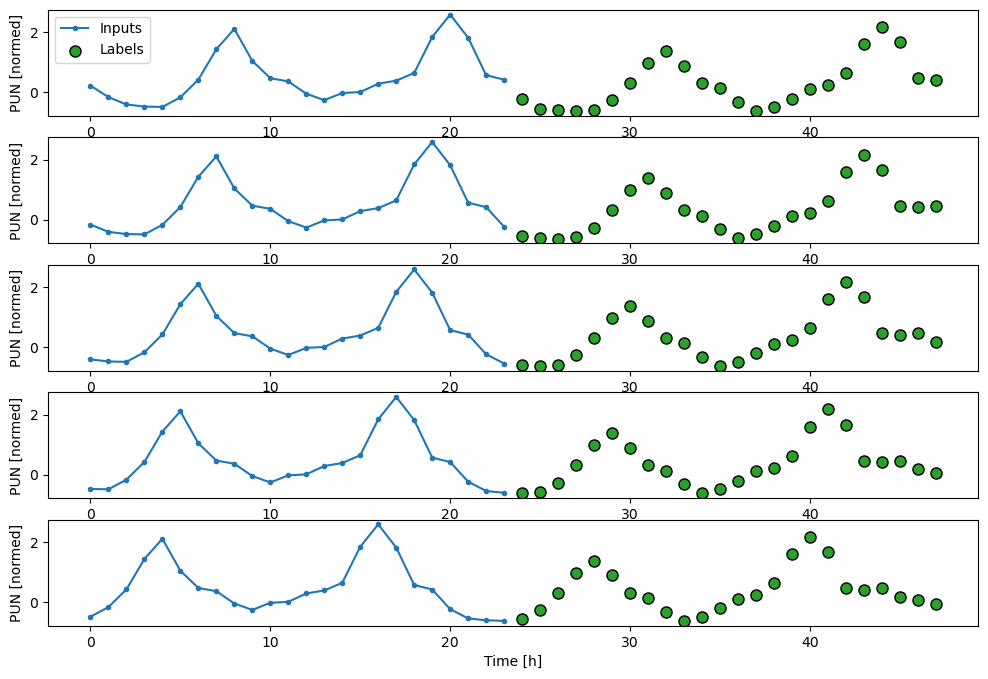

In [ ]:
w1.plot()

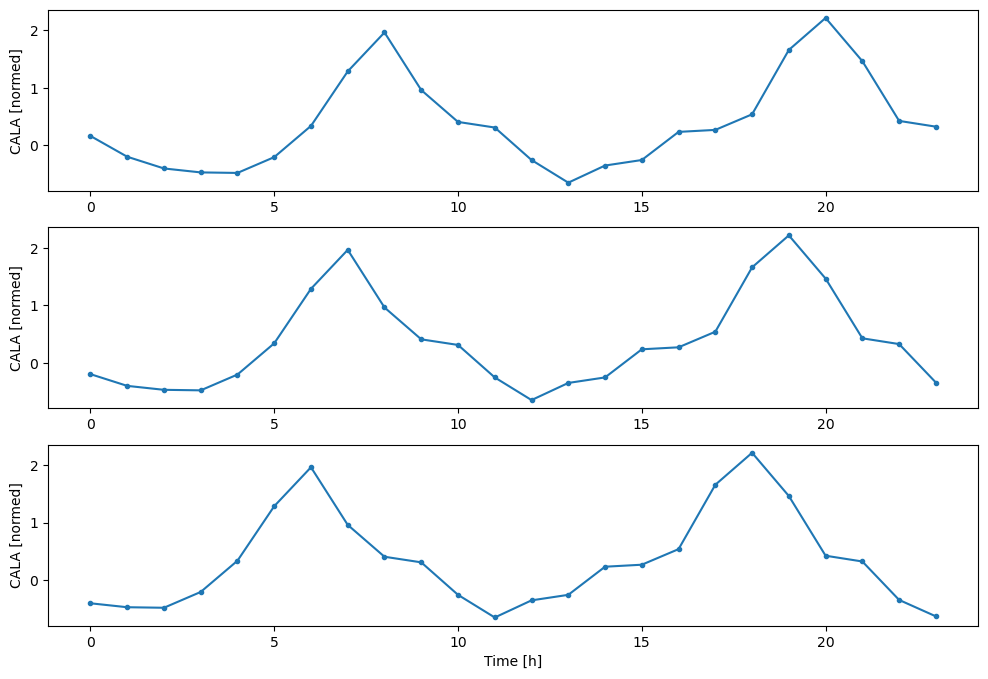

In [ ]:
w1.plot(plot_col='CALA')

In [ ]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    # train_rmse = history.history['root_mean_squared_error']
    # val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    # plt.figure(figsize=(20, 10))
    # plt.subplot(1, 2, 1)
    # plt.plot(train_rmse, label='Training RMSE')
    # plt.plot(val_rmse, label='Validation RMSE')
    # plt.legend()
    # plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [673]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Dropout, LayerNormalization

class TransformerModel(tf.keras.Model):
    def __init__(self, input_size, output_size, num_heads, num_encoder_layers, num_decoder_layers):
        super(TransformerModel, self).__init__()

        self.encoder = tf.keras.Sequential([
            Dense(input_size, activation='relu'),
            LayerNormalization(),
        ])

        self.transformer = tf.keras.layers.Transformer(
            num_heads=num_heads,
            num_layers=num_encoder_layers,
        )

        self.decoder = tf.keras.Sequential([
            Dense(64, activation='relu'),
            Dense(output_size),
        ])

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.transformer(x)
        output = self.decoder(x)
        return output


In [672]:
input_shape[1]

12

In [674]:
input_size = input_shape[1]  # Numero di features di input 
output_size = 1
num_heads = 4  # a caso
num_encoder_layers = 6  
num_decoder_layers = 6  


AttributeError: module 'tensorflow.keras.layers' has no attribute 'Transformer'

In [676]:
!pip install --upgrade tensorflow

^C


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Giova\\anaconda3_new\\Lib\\site-packages\\google\\~upb\\_message.pyd'
Consider using the `--user` option or check the permissions.



  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorboard<2.16,>=2.15 from https://files.pythonhosted.org/packages/6e/0c/1059a6682cf2cc1fcc0d5327837b5672fe4f5574255fa5430d0a8ceb75e9/tensorboard-2.15.1-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-estimator<2.16,>=2.15.0 from https://files.pythonhosted.org/packages/b6/c8/2f823c8958d5342eafc6dd3e922f0cc4fcf8c2e0460284cc462dae3b60a0/tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for keras<2.16,>=2.15.0 from https://files.pythonho

In [ ]:
model = TransformerModel(input_size, output_size, num_heads, num_encoder_layers, num_decoder_layers)

# Compila il modello
model.compile(optimizer='adam', loss='mse')

# Esempio di dati di input e target (sostituisci con i tuoi dati)
# Utilizza tutte le colonne eccetto 'PUN' come input e 'PUN' come target
input_data = df.drop('PUN', axis=1).values
target_data = df['PUN'].values

# Training del modello
epochs = 10
model.fit(input_data, target_data, epochs=epochs)

In [262]:
''' Message: Multi head attention is used to provide multiple attentions that are 
combined to provide the relationship btwn each word with others
(a word can be probably be refering to 2 words)
'''

' Message: Multi head attention is used to provide multiple attentions that are \ncombined to provide the relationship btwn each word with others\n(a word can be probably be refering to 2 words)\n'